# Week 3 - Rigid Body Kinematics II

This week, we dive into modern attitude coordinate sets, including:

- **Principal Rotation Vectors**
- **Euler Parameters (quaternions)**
- **Classical Rodrigues Parameters**
- **Modified Rodrigues Parameters**
- **Stereographic Orientation Parameters**

For each set, we will explore the concepts of attitude addition and subtraction, and how to map these sets to other coordinate systems.

<ins>**Learning Objectives**</ins>

1. **Translate Between Various Sets of Attitude Descriptions**:
   - **Rotation Matrix**: Understand how rotations can be represented using matrices.
   - **Euler Angles**: Learn the three angles that describe orientations.
   - **Principal Rotation Parameters**: Get to grips with parameters that define a single rotation about an axis.
   - **Quaternions**: Discover how these four-parameter sets offer a compact and efficient way to describe orientations.
   - **Classical Rodrigues Parameters**: Study this set of parameters for efficient rotation representation.
   - **Modified Rodrigues Parameters**: Learn about this modified set for even more stability in certain calculations.
<br><br>

2. **Add and Subtract Relative Attitude Descriptions**:
   - Understand how to combine or separate orientation descriptions to track the movement of rigid bodies.
<br><br>

3. **Integrate Attitude Descriptions Numerically**:
   - Learn methods to predict orientations over time using numerical integration, essential for simulations and real-time applications.
<br><br>

4. **Derive the Fundamental Attitude Coordinate Properties**:
   - Explore the intrinsic properties of rigid bodies and how these properties are captured by different attitude coordinate sets.
<br><br>

By the end of this module, you'll be well-versed in various modern attitude coordinate sets and equipped with the tools to switch between them, perform calculations, and predict the movement of rigid bodies in space.

---

In [1]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

# Functions from Module 2 Notebook (that are being re-used)

In [2]:
'''
The definitions of Rotation Matrices
--------------------------------------------------------------------------------------------------------------------------------------------------------
    - The rotation abt the 1st principle axis (x-axis) is defined by the angle 'psi'
    - The rotation abt the 2nd principle axis (y-axis) is defined by the angle 'theta'
    - The rotation abt the 3rd principle axis (z-axis) is defined by the angle 'phi'
'''

def rotation_matrix_x(phi, transformation_type='passive'):
    """Generate rotation matrix for a roll (rotation about the x-axis).
    
    Args:
        phi (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for x-axis rotation.
    """
    phi = np.radians(phi)
    c, s = np.cos(phi), np.sin(phi)
    matrix = np.array([[1, 0, 0], 
                       [0, c, s], 
                       [0, -s, c]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

def rotation_matrix_y(theta, transformation_type='passive'):
    """Generate rotation matrix for a pitch (rotation about the y-axis).
    
    Args:
        theta (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for y-axis rotation.
    """
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    matrix = np.array([[c, 0, -s], 
                       [0, 1, 0], 
                       [s, 0, c]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

def rotation_matrix_z(psi, transformation_type='passive'):
    """Generate rotation matrix for a yaw (rotation about the z-axis).
    
    Args:
        psi (float): The angle of rotation in degrees.
        transformation_type (str): Specifies the type of transformation, 'passive' (default) or 'active'.
    
    Returns:
        numpy.ndarray: The rotation matrix for z-axis rotation.
    """
    psi = np.radians(psi)
    c, s = np.cos(psi), np.sin(psi)
    matrix = np.array([[c, s, 0], 
                       [-s, c, 0], 
                       [0, 0, 1]])
    if transformation_type == 'active':
        return matrix.T
    return matrix

In [3]:
def initialize_ref_frame(fig, frame_matrix, frame_label, colors, is_static=False):
    """
    Initializes vectors on the provided Plotly figure as either static or dynamic using a color dictionary.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the frame vectors will be added.
        frame_matrix (np.ndarray): A 3x3 matrix representing the orientation of the frame, where each column is a unit vector (i, j, k).
        frame_label (str): The base label for the frame vectors ('N' for the N-frame, 'E' for the E-frame).
        colors (dict): A dictionary specifying the colors for each vector, keyed by 'i', 'j', 'k'.
        is_static (bool, optional): If True, the frame will be added as static (with dotted lines). 
                                    If False, it will be added as dynamic (with solid lines). 
                                    Defaults to False.

    Returns:
        list: A list of trace indices added to the figure.

    Note:
        - This function modifies the provided `fig` object in place by adding traces representing the frame vectors. It does not return a new figure.
        - The `line_style` is set to 'dot' for static frames and 'solid' for dynamic frames to visually distinguish between them.
        - The function uses the `frame_matrix` to extract the vectors corresponding to the axes (i, j, k) 
          and assigns the specified colors from the `colors` dictionary.
        - The `frame_label` is appended with a suffix to indicate whether the frame is static or dynamic.
        - The `trace_indices` list stores the indices of the added traces. 
          The `len(fig.data) - 1` expression is used to get the index of the most recently added trace, 
          as `len(fig.data)` gives the total number of traces in the figure, and subtracting 1 gives the index of the last added trace.

    Example:
        colors = {'i': 'red', 'j': 'green', 'k': 'blue'}
        frame_matrix = np.eye(3)
        fig = go.Figure()
        trace_indices = initialize_ref_frame(fig, frame_matrix, 'N', colors, is_static=True)
        print(trace_indices)  # Output should be [0, 1, 2] for the first call
    """
    line_style = 'dot' if is_static else 'solid'
    
    suffix = " (static)" if is_static else ""
    
    axis_labels = ['i', 'j', 'k'] 

    trace_indices = []

    for i, axis in enumerate(axis_labels):
        vec = frame_matrix[i, :]
        name = f'{frame_label}_{axis}{suffix}'
        color = colors[axis]  # Access color using axis label as key
        trace = go.Scatter3d(x=[0, vec[0]], 
                             y=[0, vec[1]], 
                             z=[0, vec[2]],
                             mode='lines+markers', 
                             name=name,
                             marker=dict(color=color),
                             line=dict(dash=line_style, color=color))
        fig.add_trace(trace)

        trace_indices.append(len(fig.data)-1)

    return trace_indices

def setup_animation_scene(fig, frames, title):
    """
    Configures animation controls and layout settings for a Plotly figure.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the controls will be added.
        frames (list): List of animation frames to be included in the slider control.
        title (str): The title to set for the animation scene.

    Notes:
        - Animation Controls: Adds interactive controls for playing and stepping through animation frames.
        - Button Configuration: 'Play' button starts the animation immediately with smooth transitions.
        - Slider Mechanism: Slider allows navigation to specific frames for detailed examination.
        - Current Value Display: Displays the current frame number during the animation.
        - Layout Configuration: Ensures a fixed aspect ratio and consistent spatial references.
        - Scene Dimensions: Sets dimensions for comfortable viewing.
        - Usability and Interactivity: Enhances the visualization's effectiveness for presentations and educational purposes.
    """
    # Define the 'Play' button
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 100, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    # Define the slider steps
    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 100, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    # Update the figure layout with animation controls and scene settings
    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.13,
                                    "x": -0.02,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": 0,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=1000,
                      height=800,
                      template='presentation',
                      scene={"aspectmode": 'cube',
                             "xaxis": {"range": [-1, 1], "autorange": False},
                             "yaxis": {"range": [-1, 1], "autorange": False},
                             "zaxis": {"range": [-1, 1], "autorange": False}},
                      title=title)

# 3.1) Principal Rotation Vectors

An extension of Euler angles, the Principal Rotation Vector (PRV) avoids the singularity problem in Euler angle representation by having a 'special' vector, through which a single rotation allows an object to re-orient from one frame to another.

## 3.1.1 - Euler's Principal Rotation Theorem

Euler's Theorem states:

>  A rigid body or coordinate reference frame can be brought from an arbitrary initial orientation to an arbitrary final orientation by a single rigid rotation through a principal angle $\Phi$ about the principal axis $\hat{e}$; the principal axis is a judicious axis fixed in both the initial and final orientation.

**<ins>Implications</ins>**<br>
- The theorem highlights a **judicious axis**, fixed in both initial and final orientations, about which the rotation occurs.
- The rotation's uniqueness is determined by the principal axis and angle, providing a concise representation of orientation change.

**<ins>Last Statement of Theorem</ins>**<br>
"the principal axis is a judicious axis fixed in both the initial and final orientation"

This indicates that the principal axis unit vector will have the same vector components in both the initial (inertial) and final (body) frames:

$$
\hat{e} = e_{b1} \hat{b}_1 + e_{b2} \hat{b}_2 + e_{b3} \hat{b}_3 \\
$$

$$
\hat{e} = e_{n1} \hat{n}_1 + e_{n2} \hat{n}_2 + e_{n3} \hat{n}_3 \\
$$

$$
\text{where, } e_{bi} = e_{ni} = e_i
$$

Using the rotation matrix $[C]$, the frame vector components in $\hat{e}$ in $B$ and $N$ frames can be related through:

$$
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
=
[C]
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
$$

**<ins>Principal Axis as an Eigenvector</ins>**<br>
It is evident that $\hat{e}$ must be an eigenvector of $[C]$ with an eigenvalue of +1. This eigenvector is unique up to a sign of $\hat{e}$ or $\Phi$. $\hat{e}$ is undefined for a zero rotation. There are four possible principal rotations: 
1. $(\hat{e}, \Phi)$
2. $(-\hat{e}, -\Phi)$
3. $(\hat{e}, \Phi')$
4. $(-\hat{e}, -\Phi')$

where $\Phi' = \Phi - 2\pi$.

## 3.1.2 - Relationship to Direction Cosine Matrix (DCM)

- The DCM expresses the orientation of a frame in three-dimensional space. 
- PRV components can be directly related to the DCM, offering an elegant way to describe orientation changes.

We can express the $[C]$ matrix in terms of PRV components as:

$$
[C] = \begin{bmatrix}
e_1^2 \Sigma + c\Phi & e_1e_2 \Sigma + e_3s\Phi & e_1e_3 \Sigma - e_2s\Phi \\
e_2e_1 \Sigma - e_3s\Phi & e_2^2 \Sigma + c\Phi & e_2e_3 \Sigma + e_1s\Phi \\
e_3e_1 \Sigma + e_2s\Phi & e_3e_2 \Sigma - e_1s\Phi & e_3^2 \Sigma + c\Phi
\end{bmatrix}
$$

Where $\Sigma = 1 - c\Phi$, 
$s\Phi = \sin{\Phi}$ & 
$c\Phi = \cos{\Phi}$

The inverse transformation, to get back, from the DCM $[C]$ to PRV is found by inspecting the matrix structure:

$$
\cos\Phi = \frac{1}{2} (C_{11} + C_{22} + C_{33} - 1)
$$

$$
\hat{e} 
=
\begin{bmatrix}
e_1 \\
e_2 \\
e_3
\end{bmatrix}
=
\frac{1}{2\sin\Phi}
\begin{bmatrix}
C_{23} - C_{32} \\
C_{31} - C_{13} \\
C_{12} - C_{21}
\end{bmatrix}
$$

And $\Phi' = \Phi - 2\pi$.

In [4]:
def prv_to_rotation_matrix(e, phi_deg):
    """
    Converts a Principal Rotation Vector (PRV) to a rotation matrix.

    Args:
        e (np.array)   : The unit vector of the PRV.
        phi_deg (float): The rotation angle of the PRV in degrees.

    Returns:
        np.array: A 3x3 rotation matrix.
    """
    # Convert the angle from degrees to radians
    phi_rad = np.radians(phi_deg)
    
    # Calculate the cosine and sine of the angle
    c_phi = np.cos(phi_rad)
    s_phi = np.sin(phi_rad)
    
    # Calculate the matrix Sigma
    Sigma = 1 - c_phi

    # Ensure e is a float array to avoid UFuncTypeError during in-place operations
    e = np.array(e, dtype=float)
    
    # Normalize e vector to ensure it's a valid unit vector
    e /= np.linalg.norm(e)
    
    # Decompose the unit vector into its components
    e1, e2, e3 = e
    
    # Construct the rotation matrix using the given formula
    C = np.array([[((e1**2)*Sigma + c_phi), (e1*e2*Sigma + e3*s_phi), (e1*e3*Sigma - e2*s_phi)],
                  [(e2*e1*Sigma - e3*s_phi), ((e2**2)*Sigma + c_phi), (e2*e3*Sigma + e1*s_phi)],
                  [(e3*e1*Sigma + e2*s_phi), (e3*e2*Sigma - e1*s_phi), ((e3**2)*Sigma + c_phi)]])

    return C

In [5]:
def rotation_matrix_to_prv(C):
    """
    Converts a rotation matrix to a Principal Rotation Vector (PRV).

    Args:
        C (np.array): A 3x3 rotation matrix.

    Returns:
        tuple: A PRV represented as (e_vector, phi_angle).
    """
    # Compute the angle phi from the trace of the rotation matrix
    trace_C = np.trace(C)
    phi = np.arccos((trace_C - 1) / 2)
    
    # Handle edge cases where phi is 0 or π
    if np.isclose(phi, 0) or np.isclose(phi, np.pi):
        
        # For phi=0, no rotation, the axis can be arbitrary, choose x-axis for simplicity
        # For phi=π, rotation by 180 degrees, find axis by identifying non-zero component
        e = np.array([1, 0, 0])  # Arbitrary axis, could also check for non-diagonal elements
    
    else:
        # Compute the unit vector e from the off-diagonal elements of the matrix C
        e = (1 / (2 * np.sin(phi))) * np.array([C[1, 2] - C[2, 1],
                                                C[2, 0] - C[0, 2],
                                                C[0, 1] - C[1, 0]])
        # Normalize the unit vector to ensure it's a valid unit vector
        e /= np.linalg.norm(e)

    # Ensure the angle phi is in the range [0, 2*pi)
    phi = np.mod(phi, 2 * np.pi)

    return e, phi

In [6]:
'''
Concept check on PRV and DCM Relation - Question 4
Given the PRV and Angle, check if the DCMs are all equal
'''
c = prv_to_rotation_matrix(np.array([1,0,0]), 30)
print(c)
print('--------------------------------------')

c_1 = prv_to_rotation_matrix(np.array([-1,0,0]), -30)
print(c_1)

[[ 1.         0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [ 0.        -0.5        0.8660254]]
--------------------------------------
[[ 1.        -0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [-0.        -0.5        0.8660254]]


In [7]:
'''
Concept check on PRV and DCM Relation - Question 6
Given the PRV and Angle, check if the DCMs are all equal
'''

BN = np.array([[0.925417, 0.336824, 0.173648],
               [0.0296956, -0.521281, 0.852869],
               [0.377786, -0.784102, -0.492404]])

e, phi = rotation_matrix_to_prv(BN)
print(f"PRV:\t{e}")
print(f"Phi:\t{phi}")

PRV:	[0.97555056 0.12165575 0.18303274]
Phi:	2.1461529124034975


## 3.1.3 - PRV Operations

<ins>**PRV Addition**</ins>

For the addition of two PRVs using:

- **DCM method**:
  The combined rotation is the result of the product of two rotations:
  $$
  [FN(\Phi, \hat{e})] = [FB(\Phi_2, \hat{e}_2)] [BN(\Phi_1, \hat{e}_1)]
  $$

- **Direct method**:
  The resultant PRV angle and axis are computed as:

  $$
  \Phi = 2 \cos^{-1} \left( \cos \frac{\Phi_1}{2} \cos \frac{\Phi_2}{2} - \sin \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_1 \cdot \hat{e}_2 \right)
  $$

  $$
  \hat{e} = \frac{ \cos \frac{\Phi_2}{2} \sin \frac{\Phi_1}{2} \hat{e}_1 + \cos \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_2 + \sin \frac{\Phi_1}{2} \sin \frac{\Phi_2}{2} \hat{e}_1 \times \hat{e}_2 }{\sin \frac{\Phi}{2}}
  $$

<ins>**PRV Subtraction**</ins>

For the subtraction of Principal Rotation Vectors using the:

- **DCM method**:
  $$
  [FN(\Phi, \hat{e})] = [FB(\Phi_2, \hat{e}_2)] [BN(\Phi_1, \hat{e}_1)]^T
  $$

- **Direct method**:
  To compute the resulting angle Φ₂ and unit vector ê₂:
  
  $$
  \Phi_2 = 2 \cos^{-1} \left( \cos \frac{\Phi}{2} \cos \frac{\Phi_1}{2} + \sin \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e} \cdot \hat{e}_1 \right)
  $$

  $$
  \hat{e}_2 = \frac{1}{\sin \frac{\Phi_2}{2}}
  \left(
  \cos \frac{\Phi_1}{2} \sin \frac{\Phi}{2} \hat{e}
  - \cos \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e}_1
  + \sin \frac{\Phi}{2} \sin \frac{\Phi_1}{2} \hat{e} \times \hat{e}_1
  \right)
  $$

Here, $\Phi_1$ and $\Phi_2$ represent the rotation angles for the first and second PRVs, respectively, and $\hat{e}_1$ and $\hat{e}_2$ are the corresponding unit vectors along the principal axes of rotation. The resultant PRV, represented by $\Phi$ and $\hat{e}$, combines these rotations.

Note: The cross product $\hat{e}_1 \times \hat{e}_2$ and the dot product $\hat{e}_1 \cdot \hat{e}_2$ are vector operations. The cross product results in a vector that is perpendicular to both $\hat{e}_1$ and $\hat{e}_2$, and the dot product results in a scalar that reflects the magnitude of parallelism between $\hat{e}_1$ and $\hat{e}_2$.

In [8]:
''' 
Concept check on PRV Operations - Question 1
'''
BN = prv_to_rotation_matrix(np.array([1,0,0]), 90)

NB = np.linalg.inv(BN)

e, phi = rotation_matrix_to_prv(NB)
print(e)
print(phi)

[-1.  0.  0.]
1.5707963267948966


In [9]:
''' 
Concept check on PRV Operations - Question 2
'''
euler_321_mat = np.matmul(np.matmul(rotation_matrix_z(120), rotation_matrix_y(-10)), rotation_matrix_x(20))

e, phi = rotation_matrix_to_prv(euler_321_mat.T)
print(e)
print(phi)

[-0.01407696  0.22308585 -0.97469715]
2.085985724059574


In [10]:
''' 
Concept check on PRV Operations - Question 3
'''
FB = np.array([[1, 0, 0], 
               [0, 0, 1], 
               [0, -1, 0]])

BN = FB

FN = np.matmul(FB, BN)

e, phi = rotation_matrix_to_prv(FN)
print(e)
print(phi)

[1 0 0]
3.141592653589793


## 3.1.4 - PRV Kinematic Differential Equation

- Mapping from body angular velocity vector to PRV rates:

$$
\dot{\gamma} = \left[ I_{3 \times 3} + \frac{1}{2} \left[ \tilde{\gamma} \right] + \frac{1}{\Phi^2} \left( 1 - \frac{\Phi}{2} \cot \left( \frac{\Phi}{2} \right) \right) \left[ \tilde{\gamma} \right]^2 \right] \omega_{B}
$$

- Mapping from PRV rates to body angular velocity vector:

$$
\omega_{B} = \left[ I_{3 \times 3} - \left( 1 - \cos \Phi \right) \frac{1}{\Phi^2} \left[ \tilde{\gamma} \right] + \left( \Phi - \sin \Phi \right) \frac{1}{\Phi^3} \left[ \tilde{\gamma} \right]^2 \right] \dot{\gamma}
$$

## 3.1.5 - Visualizing PRV

In [11]:
def PRV_rotation_animation(axis, angle, steps=30):
    """
    Creates a 3D animation of a rotation about a principal rotation vector (PRV) and displays the final orientation of the frame.

    Args:
        axis (list, tuple, np.ndarray): The unit vector representing the axis of rotation.
        angle (float): The magnitude of the rotation about the axis in degrees.
        steps (int, optional): The total number of steps in the animation. Defaults to 30.

    Returns:
        plotly.graph_objects.Figure: The figure object containing the animation.

    Notes:
    - The function dynamically calculates rotation matrices for each step based on the PRV method.
      It applies these rotations to an initial orientation matrix to visually represent these orientations in a Plotly figure.
    
    - This approach aids in visualizing the rotation from a starting point of no rotation, making it intuitive to understand complex rotational dynamics.
    
    - The animation controls allow for interactive exploration of the rotation sequence, enhancing the educational and analytical value of the visualization.
    """
    # Initialize the figure for 3D visualization
    fig = go.Figure()

    # Define initial orientation as an identity matrix
    N_frame = np.eye(3)

    # Define colors for axes and the rotation axis visualization
    colors = {'i': 'red', 
              'j': 'green', 
              'k': 'blue', 
              'axis': 'purple'}

    # Initialize the static frame (N-frame)
    initialize_ref_frame(fig, N_frame, 'N', colors, is_static=True)

    # Initialize the dynamic frame (E-frame) to visualize rotations
    initialize_ref_frame(fig, N_frame, 'E', colors, is_static=False)

    # Compute rotation matrix for each step using the PRV to rotation matrix conversion
    rotation_matrices = []
    for step in range(steps + 1):
        # Calculate the interpolation angle for the current step
        interpolated_angle = (step / steps) * angle
        
        # Use the prv_to_rotation_matrix function to generate the rotation matrix
        R_matrix = prv_to_rotation_matrix(axis, interpolated_angle)
        rotation_matrices.append(R_matrix)

    # Printing relevant Attitude representations
    # Euler angles are representative of 3-2-1 sequence
    DCM = rotation_matrices[-1]
    first_rot = np.degrees(np.arctan2(DCM[0][1], DCM[0][0]))
    second_rot = np.degrees(np.arcsin(-DCM[0][2]))
    third_rot = np.degrees(np.arctan2(DCM[1][2], DCM[2][2]))
    
    print(f"Axis-Angle (degrees): {axis}, {angle}")
    print("----------------------------------------------------")
    print(f"DCM:\n{DCM}")
    print("----------------------------------------------------")
    print(f"Euler Angles (321 sequence): <{first_rot}, {second_rot}, {third_rot}>")

    # Generate frames for animation
    frames = []
    for i, R_matrix in enumerate(rotation_matrices):
        
        E_frame = np.matmul(R_matrix, N_frame)

        # List of frames
        frame_data = [go.Scatter3d(x=[0, vec[0]], 
                                   y=[0, vec[1]], 
                                   z=[0, vec[2]],
                                   mode='lines+markers',
                                   name=f'E_{chr(105+j)}',
                                   marker=dict(color=colors['i' if j == 0 else 'j' if j == 1 else 'k']))for j, vec in enumerate(E_frame)]


        frames.append(go.Frame(data=frame_data, name=str(i), traces=[3, 4, 5]))

    # Calculate the norm of the axis
    axis_norm = np.linalg.norm(axis)

    # Plot the rotation axis as a line extending from the origin
    axis_normalized = axis / np.array(axis_norm)
    
    # Create hover text for the endpoint of the line
    endpoint_hover_text = f"x: {axis_normalized[0]:.2f}<br>y: {axis_normalized[1]:.2f}<br>z: {axis_normalized[2]:.2f}<br>Norm: {np.linalg.norm(axis_normalized):.2f}"
    

    fig.add_trace(go.Scatter3d(x=[0, axis_normalized[0]], 
                               y=[0, axis_normalized[1]], 
                               z=[0, axis_normalized[2]],
                               mode='lines+markers',
                               line=dict(color=colors['axis'], width=5),
                               name='Rotation Axis (normalized)',
                               hoverinfo='text+name',  
                               text=endpoint_hover_text))

    # Configure the figure with generated frames for animation
    fig.frames = frames
    setup_animation_scene(fig, frames, "PRV Rotation Animation")

    return fig

In [39]:
# Example usage: Positive Axis and Positive Angle (short rotation)
axis = [1, 1, 1]  
angle = 180
fig = PRV_rotation_animation(axis, angle)
fig.show()

Axis-Angle (degrees): [1, 1, 1], 180
----------------------------------------------------
DCM:
[[-0.33333333  0.66666667  0.66666667]
 [ 0.66666667 -0.33333333  0.66666667]
 [ 0.66666667  0.66666667 -0.33333333]]
----------------------------------------------------
Euler Angles (321 sequence): <116.56505117707796, -41.8103148957786, 116.56505117707796>


In [13]:
# Example usage: Negative Axis and Negative Angle (short rotation)
axis = [-1, -1, -1]  
angle = -25
fig = PRV_rotation_animation(axis, angle)
fig.show()

Axis-Angle (degrees): [-1, -1, -1], -25
----------------------------------------------------
DCM:
[[ 0.93753852  0.2752295  -0.21276803]
 [-0.21276803  0.93753852  0.2752295 ]
 [ 0.2752295  -0.21276803  0.93753852]]
----------------------------------------------------
Euler Angles (321 sequence): <16.360449383348005, 12.284615359808903, 16.360449383348005>


In [14]:
# Example usage: Positive Axis and Positive Angle (long rotation)
axis = [1, 1, 1]  
angle = 25 - 360
fig = PRV_rotation_animation(axis, angle)
fig.show()

Axis-Angle (degrees): [1, 1, 1], -335
----------------------------------------------------
DCM:
[[ 0.93753852  0.2752295  -0.21276803]
 [-0.21276803  0.93753852  0.2752295 ]
 [ 0.2752295  -0.21276803  0.93753852]]
----------------------------------------------------
Euler Angles (321 sequence): <16.360449383347994, 12.284615359808896, 16.360449383347994>


In [15]:
# Example usage: Negative Axis and Negative Angle (long rotation)
axis = [-1, -1, -1]  
angle = - (25 - 360)
fig = PRV_rotation_animation(axis, angle)
fig.show()

Axis-Angle (degrees): [-1, -1, -1], 335
----------------------------------------------------
DCM:
[[ 0.93753852  0.2752295  -0.21276803]
 [-0.21276803  0.93753852  0.2752295 ]
 [ 0.2752295  -0.21276803  0.93753852]]
----------------------------------------------------
Euler Angles (321 sequence): <16.360449383347994, 12.284615359808896, 16.360449383347994>


# 3.2) Quaternions/Euler-Rodrigues Parameters

Quaternions, also referred to as **Euler-Rodrigues Parameters**, are a number system used to represent rotations in three-dimensional space. They provide a robust way to describe rotations, avoiding singularities like **gimbal lock**, which can occur when using Euler angles. Quaternions are commonly used in applications like spacecraft attitude control due to their computational efficiency.


**<ins>Brief History</ins>**

- **Leonhard Euler (1776)**: Euler introduced the **finite rotation theorem**, which mathematically states that **any arbitrary 3D rotation** can be represented as a single rotation about a fixed axis by a specific angle. This theorem provided a **mathematical description** of rotations, reducing the complexity of 3D rotations to an axis-angle representation. However, it did not provide a method to perform the actual rotation on a vector.

- **Olinde Rodrigues (1840)**: Rodrigues expanded on Euler’s work with a **geometric formula**—known as **Rodrigues' rotation formula**—that provided a practical method for computing the rotated position of a vector around an axis for a given angle. This made Euler’s abstract theorem computationally useful by explaining **how** to rotate vectors in space.

- **William Rowan Hamilton (1843)**: Hamilton developed **quaternions**, a more general mathematical structure that extends Euler-Rodrigues parameters. Quaternions consist of one real part and three imaginary parts, expressed as:

  $$ q = a + bi + cj + dk $$

  where \(a, b, c, d\) are real numbers, and \(i, j, k\) are the imaginary units. Quaternions are not just limited to describing 3D rotations—they are part of a broader algebraic system used in mathematics and physics. However, in the context of attitude dynamics, we focus on the portion of quaternions used to efficiently compute rotations without the pitfalls of gimbal lock. Quaternions allow for smooth and stable 3D rotations, which makes them essential for applications like spacecraft control and 3D computer graphics.

  While quaternions are mathematically extensive and have applications in various fields, our focus here is on their utility in representing and calculating 3D rotations.


**<ins>Euler, Rodrigues, and Hamilton in Context</ins>**

- **Euler (1776)** provided a **conceptual framework** with his **finite rotation theorem**: he described 3D rotations as happening around a single axis by a fixed angle, but his work was an abstract description.
  
- **Rodrigues (1840)** introduced a **geometric formula** that made Euler’s abstract idea **practically usable** by explaining how to rotate a vector based on an axis and angle.

- **Hamilton (1843)** developed **quaternions**, a more general algebraic structure, which includes a part specifically used to describe 3D rotations. While quaternions extend beyond rotations, their efficiency in computing rotations without ambiguities makes them highly useful in fields like aerospace.


**<ins>Hamiltonian vs. Schuster's Version</ins>**  
In spacecraft attitude determination, **quaternions** (or **Euler-Rodrigues Parameters**) are widely used to describe a spacecraft’s orientation relative to a reference frame. Two common formulations are:

- **Hamiltonian Quaternions**: The original formulation by Hamilton, used in mathematics and physics.
  
- **Schuster's Version**: Adapted by **Malcolm D. Schuster** for aerospace applications, optimized for attitude dynamics and numerical stability, which is important for real-time control systems.

In aerospace, **Schuster’s version** is preferred because it simplifies calculations and enhances stability, making it more practical for spacecraft attitude control and simulation.

## 3.2.1 - Definition of Quaternions/EP

Euler Parameters, also referred to as quaternions, provide a robust way to represent rotations in three-dimensional space without the singularity issues inherent in Euler angles. Here's how they're defined:

- $\beta_0 = \cos(\frac{\phi}{2})$
- $\beta_1 = e_1 \sin(\frac{\phi}{2})$
- $\beta_2 = e_2 \sin(\frac{\phi}{2})$
- $\beta_3 = e_3 \sin(\frac{\phi}{2})$

where $\phi$ is the rotation angle, and $e_1, e_2, e_3$ are the components of the unit vector along the axis of rotation. This unit vector defines the direction of the rotation axis.

<ins>**Constraints**</ins>
Euler Parameters must satisfy these constraints to be valid:
- The sum of the squares of the components of the rotation axis vector must add up to one: $$e_1^2 + e_2^2 + e_3^2 = 1$$.
- The sum of the squares of all Euler Parameters must also equal one: $$\beta_0^2 + \beta_1^2 + \beta_2^2 + \beta_3^2 = 1$$.

This ensures that all Euler Parameters lie on the surface of a four-dimensional unit hypersphere, maintaining their normalization.

<ins>**Relation to PRV and Uniqueness of EP**</ins><br>
Euler Parameters (EPs) and Principal Rotation Vectors (PRVs) both offer robust methods to represent orientations in 3D space, highlighting different aspects of rotations:
- **Euler Parameters (EPs):** Defined by components:
  - $\beta_0 = \cos(\phi/2)$
  - $\beta_i = e_i \sin(\phi/2)$ for $i=1,2,3$,
  representing the rotation around the unit vector axis defined by $e_1, e_2, e_3$ and the rotation angle $\phi$.<br><br>
- **Principal Rotation Vectors (PRVs):** Directly use the rotation axis and angle to define rotation, but similar to EPs, the description is not unique. There are four possible representations for the same orientation, highlighting the non-uniqueness inherent in rotational representations.

Both EPs and PRVs can describe the same rotation in two equivalent but seemingly opposite ways:
1. **Standard and Negative Rotation:**
   - Rotating by $(e, \phi)$ is equivalent to rotating by $(-e, -\phi)$. This reflects the idea that rotating 'forward' by an angle can also be achieved by rotating 'backward' by the full circle minus that angle.
   - In terms of Euler Parameters:
     - $\beta_0' = \cos(-\phi/2) = \cos(\phi/2) = \beta_0$
     - $\beta_i' = -e_i \sin(-\phi/2) = e_i \sin(\phi/2) = \beta_i$ for $i=1,2,3$<br><br>
2. **Long Way Round (Alternative Rotation):**
   - An alternative representation is considering $\phi' = \phi - 2\pi$, which describes taking a longer route to achieve the same orientation.
   - For EPs:
     - $\beta_0' = \cos(\phi/2 - \pi) = -\cos(\phi/2) = -\beta_0$
     - $\beta_i' = e_i \sin(\phi/2 - \pi) = -e_i \sin(\phi/2) = -\beta_i$

<ins>**Intuitive Understanding of Quaternions in Spacecraft Attitude Dynamics**</ins>

Quaternions are a powerful tool that combine the axis of rotation and the angle of rotation into a single, efficient representation of spacecraft orientation.

---

<ins>**1) Quaternions: Combining Axis and Angle**</ins>

Quaternions provide a unified way to represent rotations by combining the **axis of rotation** and the **angle of rotation**.

- **Axis-Angle Representation**: Any rotation is defined by an axis vector $ \mathbf{u} $ (the direction of rotation) and an angle $ \phi $ (how much to rotate).

- **Quaternion Components**:
  - **Scalar Part ($ q_0 $)**: Relates to the rotation angle.
  - **Vector Part ($ q_1, q_2, q_3 $)**: Encodes the rotation axis.

---

<ins>**2) The Half-Angle Concept**</ins>

Using half the rotation angle in quaternions ensures smooth and unique representations.

- **Mathematical Formulation**:
  - $ q_0 = \cos\left( \dfrac{\phi}{2} \right) $
  - $ [q_1, q_2, q_3] = \sin\left( \dfrac{\phi}{2} \right) \mathbf{u} $

- **Benefits**:
  - **Unique Representation**: Avoids ambiguity in orientation.
  - **Smooth Transitions**: Enables gradual changes without sudden jumps.

---

<ins>**3) Precise Analogy: Rotating a Book**</ins>

Imagine holding a book:

- **Axis of Rotation**: Insert a pencil through the book; the pencil represents the rotation axis $ \mathbf{u} $.
- **Rotation Angle**: Rotate the book around the pencil by angle $ \phi $.

- **Quaternion Representation**:
  - **Scalar Part ($ q_0 $)**: Measures how much you've rotated $ \left( \cos\left( \dfrac{\phi}{2} \right) \right) $.
  - **Vector Part ($ q_1, q_2, q_3 $)**: Points along the pencil, scaled by $ \sin\left( \dfrac{\phi}{2} \right) $.

---

<ins>**4) Practical Benefits in Spacecraft Dynamics**</ins>

Quaternions are invaluable for controlling spacecraft attitude due to their efficiency and stability.

- **Avoiding Gimbal Lock**: Quaternions prevent the loss of rotational freedom found in Euler angles.
- **Efficient Calculations**: Simplifies combining rotations, crucial for real-time control.
- **Stable Interpolation**: Allows for smooth and precise orientation changes.

---

<ins>**5) Key Takeaways**</ins>

- **Unified Representation**: Quaternions encapsulate both rotation axis and angle.
- **Half-Angle Usage**: Essential for unique and smooth orientation representation.
- **Essential Tool**: Quaternions are vital for reliable spacecraft attitude control.

By visualizing quaternions through this analogy, we grasp how they simplify complex rotations, making them indispensable in spacecraft attitude dynamics.


## 3.2.2 - Relationship to DCMs

<ins>**Euler Parameter to DCM Relationship**</ins>

The relationship between Euler Parameters (EPs) and the Direction Cosine Matrix (DCM) is fundamental in representing rotations in 3D space. The DCM can be directly expressed using EPs as follows:

$$
C = \begin{bmatrix}
\beta_0^2 + \beta_1^2 - \beta_2^2 - \beta_3^2 & 2(\beta_1\beta_2 - \beta_0\beta_3) & 2(\beta_1\beta_3 - \beta_0\beta_2) \\
2(\beta_1\beta_2 - \beta_0\beta_3) & \beta_0^2 - \beta_1^2 + \beta_2^2 - \beta_3^2 & 2(\beta_2\beta_3 + \beta_0\beta_1) \\
2(\beta_1\beta_3 + \beta_0\beta_2) & 2(\beta_2\beta_3 - \beta_0\beta_1) & \beta_0^2 - \beta_1^2 - \beta_2^2 + \beta_3^2
\end{bmatrix}
$$

The inverse relationship to extract EPs from the DCM is as follows, where care must be taken to avoid singularities when $\beta_0 \rightarrow 0$:

$$
\beta_0 = \pm \frac{1}{2} \sqrt{C_{11} + C_{22} + C_{33} + 1}
$$
$$
\beta_1 = \frac{C_{23} - C_{32}}{4\beta_0}, \quad \beta_2 = \frac{C_{31} - C_{13}}{4\beta_0}, \quad \beta_3 = \frac{C_{12} - C_{21}}{4\beta_0}
$$

<br><br>

<ins>**Sheppard's Method for Computing Euler Parameters (EPs) from a Rotation Matrix**</ins><br>
Sheppard's method is a systematic approach to accurately derive the Euler Parameters (EPs) from a given Direction Cosine Matrix (DCM), denoted as $C$. The method unfolds in two main steps to ensure numerical stability, especially important to avoid division by small numbers that could lead to computational errors.

<ins>**Step 1: Compute the Squares of the EP Components**</ins><br>
First, determine which component of the EPs has the largest value. This is essential to avoid computational instability:

- **Square of $\beta_0$**:
  $$
  \beta_0^2 = \frac{1 + \text{trace}(C)}{4}
  $$

- **Square of $\beta_1$**:
  $$
  \beta_1^2 = \frac{1 + 2C_{11} - \text{trace}(C)}{4}
  $$

- **Square of $\beta_2$**:
  $$
  \beta_2^2 = \frac{1 + 2C_{22} - \text{trace}(C)}{4}
  $$

- **Square of $\beta_3$**:
  $$
  \beta_3^2 = \frac{1 + 2C_{33} - \text{trace}(C)}{4}
  $$

<ins>**Step 2: Compute the Remaining EP Components**</ins><br>
After identifying the largest $\beta^2$, compute the other components using the largest as a base to maintain accuracy using the following equations,

  $$
  \beta_0\beta_1 = \frac{(C_{23} - C_{32})}{4}
  $$
  $$
  \beta_0\beta_2 = \frac{(C_{31} - C_{13})}{4}
  $$
  $$
  \beta_0\beta_3 = \frac{(C_{12} - C_{21})}{4}
  $$

  $$
  \beta_1\beta_2 = \frac{(C_{12} + C_{21})}{4}
  $$
  $$
  \beta_1\beta_3 = \frac{(C_{13} + C_{31})}{4}
  $$
  $$
  \beta_2\beta_3 = \frac{(C_{23} + C_{32})}{4}
  $$

This approach allows for a robust calculation of the EPs by adapting to the specifics of the rotation matrix and ensuring all computations remain within stable numerical limits.

In [16]:
def quaternion_to_DCM(q):
    """
    Converts a quaternion to a direction cosine matrix (DCM).

    Args:
        q (np.array): A numpy array of size 4 (a row vector) representing the quaternion,
                      where q[0] is the scalar part (beta_0), and q[1], q[2], q[3] are the 
                      vector parts (beta_1, beta_2, beta_3).

    Returns:
        np.array: A 3x3 rotation matrix (DCM).

    Example:
        >>> q = np.array([1, 5, 6, 2])
        >>> quaternion_to_DCM(q)
        array([[ 0.38461538, -0.07692308,  0.91923077],
               [ 0.07692308,  0.99230769, -0.09615385],
               [-0.91923077,  0.09615385,  0.38461538]])
    """
    # Ensure q is a float array to maintain precision
    q = np.array(q, dtype=np.float64)
    
    # Check that the holonomic constraint of quaternion is satisfied, else normalize it
    q_norm = np.linalg.norm(q)
    if not np.isclose(q_norm, 1.0, atol=1e-8):
        q /= q_norm
    
    # Extract components
    q0, q1, q2, q3 = q
    
    # Compute the elements of the DCM
    C = np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2 * (q1*q2 + q0*q3),         2 * (q1*q3 - q0*q2)],
        [2 * (q1*q2 - q0*q3),           q0**2 - q1**2 + q2**2 - q3**2, 2 * (q2*q3 + q0*q1)],
        [2 * (q1*q3 + q0*q2),           2 * (q2*q3 - q0*q1),           q0**2 - q1**2 - q2**2 + q3**2]
    ])
    
    return C

# Example usage:
q = np.array([-1, 5, 6, 2])
C = quaternion_to_DCM(q)
print("Direction Cosine Matrix (DCM):\n", C)

Direction Cosine Matrix (DCM):
 [[-0.21212121  0.84848485  0.48484848]
 [ 0.96969697  0.12121212  0.21212121]
 [ 0.12121212  0.51515152 -0.84848485]]


In [17]:
def DCM_to_quaternion(dcm):
    """
    Converts a Direction Cosine Matrix (DCM) to a quaternion using a method to ensure robustness against numerical issues.
    
    Args:
        dcm (np.array): A 3x3 rotation matrix (DCM).
    
    Returns:
        np.array: A quaternion represented as a numpy array of size 4, with the scalar component as the first element.
    
    Example Usage:
        >>> dcm = np.array([[-0.21212121, 0.96969697, 0.12121212],
                            [0.84848485, 0.12121212, 0.51515152],
                            [0.48484848, 0.21212121, -0.84848485]])
        >>> quaternion = DCM_to_quaternion(dcm)
        >>> print(quaternion)
    
    Notes:
    - If the scalar component (q0) is negative, it is flipped to positive. (Ensuring shortes path of rotation)
    - Corresponding vector component is also flipped when q0 is flipped. (Shepperd's Method)
    - Flipping maintains the quaternion's correct rotational encoding.
    - Ensures the quaternion represents a rotation of less than 180 degrees.
    - Adheres to quaternion algebra for accurate 3D rotation representation.
    """
    trace = np.trace(dcm)
    q_squared = np.zeros(4)
    q_squared[0] = (1.0 + trace) / 4.0
    q_squared[1] = (1.0 + 2 * dcm[0, 0] - trace) / 4.0
    q_squared[2] = (1.0 + 2 * dcm[1, 1] - trace) / 4.0
    q_squared[3] = (1.0 + 2 * dcm[2, 2] - trace) / 4.0

    q = np.zeros(4)
    max_index = np.argmax(q_squared)

    if max_index == 0:
        q[0] = np.sqrt(q_squared[0])
        q[1] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[0])
        q[2] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[0])
        q[3] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[0])
    
    elif max_index == 1:
        q[1] = np.sqrt(q_squared[1])
        q[0] = (dcm[1, 2] - dcm[2, 1]) / (4 * q[1])
        if q[0] < 0:
            q[0] = -q[0]
            q[1] = -q[1]
        q[2] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[1])
        q[3] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[1])
        
    elif max_index == 2:
        q[2] = np.sqrt(q_squared[2])
        q[0] = (dcm[2, 0] - dcm[0, 2]) / (4 * q[2])
        if q[0] < 0:
            q[0] = -q[0]
            q[2] = -q[2]
        q[1] = (dcm[0, 1] + dcm[1, 0]) / (4 * q[2])
        q[3] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[2])

    elif max_index == 3:
        q[3] = np.sqrt(q_squared[3])
        q[0] = (dcm[0, 1] - dcm[1, 0]) / (4 * q[3])
        if q[0] < 0:
            q[0] = -q[0]
            q[3] = -q[3]
        q[1] = (dcm[2, 0] + dcm[0, 2]) / (4 * q[3])
        q[2] = (dcm[1, 2] + dcm[2, 1]) / (4 * q[3])
    
    return q

# Example Usage
dcm = np.array([[-0.21212121,  0.84848485,  0.48484848],
                [ 0.96969697,  0.12121212,  0.21212121],
                [ 0.12121212,  0.51515152, -0.84848485]])
quaternion = DCM_to_quaternion(dcm)
print(quaternion)

[ 0.12309149 -0.61545746 -0.73854895 -0.24618298]


In [18]:
# Concept Check 5, 6 - Question 1
q = np.array([0.235702, 0.471405, -0.471405, 0.707107])
C = quaternion_to_DCM(q)
print("Direction Cosine Matrix (DCM):\n", C)

Direction Cosine Matrix (DCM):
 [[-0.44444488 -0.11111228  0.88888975]
 [-0.77777842 -0.44444488 -0.44444535]
 [ 0.44444535 -0.88888975  0.11111039]]


In [19]:
# Concept Check 5, 6 - Question 3
BN = np.array([[-0.529403, -0.467056,  0.708231],
               [-0.474115, -0.529403, -0.703525],
               [ 0.703525, -0.708231,  0.0588291]])
quaternion1 = DCM_to_quaternion(BN)
print(quaternion1)

[ 0.00242542  0.48506963 -0.48506963  0.72760482]


In [20]:
# Concept Check 5, 6 - Question 4
#R =  np.matmul(rotation_matrix_x(-10), np.matmul(rotation_matrix_y(10), rotation_matrix_z(20)))
R = rotation_matrix_x(-10) @ rotation_matrix_y(10) @ rotation_matrix_z(20)
Euler_parameter = DCM_to_quaternion(R)
print(Euler_parameter)

[ 0.97600798 -0.10058188  0.07042819  0.17980985]


## 3.2.3 - Quaternion Additions (more like rotation composition)

The addition of Euler Parameters is facilitated through quaternion algebra, providing a direct method without converting to DCMs first. The operation is represented elegantly in matrix form:

$$
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
=
\begin{bmatrix}
\beta_0'' & -\beta_1'' & -\beta_2'' & -\beta_3'' \\
\beta_1'' & \beta_0'' & \beta_3'' & -\beta_2'' \\
\beta_2'' & -\beta_3'' & \beta_0'' & \beta_1'' \\
\beta_3'' & \beta_2'' & -\beta_1'' & \beta_0''
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0' \\
\beta_1' \\
\beta_2' \\
\beta_3'
\end{bmatrix}
$$

OR

$$
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
=
\begin{bmatrix}
\beta_0'' & \beta_1'' & \beta_2'' & \beta_3'' \\
-\beta_1'' & \beta_0'' & -\beta_3'' & \beta_2'' \\
-\beta_2'' & \beta_3'' & \beta_0'' & -\beta_1'' \\
-\beta_3'' & -\beta_2'' & \beta_1'' & \beta_0''
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0' \\
\beta_1' \\
\beta_2' \\
\beta_3'
\end{bmatrix}
$$

This matrix operation effectively adds two sets of Euler Parameters (quaternions), where the primes and double primes represent different rotations.

To subtract two orientations described through EPs, the orthogonality property of the 4x4 matrix is used to invert and solve for either $\beta''$ or $\beta'$ directly.

In [21]:
# Concept Check 7 - Question 1

# Given quaternions
beta_BN = np.array([0.774597, 0.258199, 0.516398, 0.258199])
beta_FB = np.array([0.359211, 0.898027, 0.179605, 0.179605])

dcm_BN = quaternion_to_DCM(beta_BN)
dcm_FB = quaternion_to_DCM(beta_FB)

dcm_FN = np.matmul(dcm_FB, dcm_BN)
beta_FN = DCM_to_quaternion(dcm_FN)
print(beta_FN)

[ 0.09274743 -0.8347305  -0.51011334  0.18549616]


In [22]:
# Concept Check 7 - Question 2

# Define the quaternions
beta_FN = np.array([0.359211, 0.898027, 0.179605, 0.179605])
beta_BN = np.array([-0.377964, 0.755929, 0.377964, 0.377964])

dcm_FN = quaternion_to_DCM(beta_FN)
dcm_BN = quaternion_to_DCM(beta_BN)

dcm_FB = np.matmul(dcm_FB, dcm_BN.T)
beta_FB = DCM_to_quaternion(dcm_FB)
print(beta_FB)

[ 6.78844282e-01 -6.10959882e-01 -4.07306295e-01  1.98358998e-07]


## 3.2.4 - Euler Parameter Kinematic Differential Equations

The differential kinematic equations of Euler Parameters (EPs) derive from the relationship between Direction Cosine Matrices (DCMs) and EPs. Despite the complexity of deriving these equations, the end results are notably elegant and useful, particularly in the context of estimation theory for applications like spacecraft orientation estimation.

<ins>**Bi-Linear Differential Equation Form**</ins><br>
The kinematic differential equations for Euler parameters can be represented in a compact bi-linear form:

$$
\begin{align*}
\frac{d}{dt}\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix} = \frac{1}{2} \begin{bmatrix}
\beta_0 & -\beta_1 & -\beta_2 & -\beta_3 \\
\beta_1 & \beta_0 & -\beta_3 & \beta_2 \\
\beta_2 & \beta_3 & \beta_0 & -\beta_1 \\
\beta_3 & -\beta_2 & \beta_1 & \beta_0 
\end{bmatrix} \begin{bmatrix}
0 \\
\omega_1 \\
\omega_2 \\
\omega_3 
\end{bmatrix}
\end{align*}
$$

<ins>**Alternative Skew-Symmetric Matrix Form**</ins><br>
The differential equation can also be reformulated using a skew-symmetric matrix, enhancing its applicability in numerical integration:

$$
\begin{align*}
\frac{d}{dt}\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix} = \frac{1}{2} \begin{bmatrix}
0 & -\omega_1 & -\omega_2 & -\omega_3 \\
\omega_1 & 0 & \omega_3 & -\omega_2 \\
\omega_2 & -\omega_3 & 0 & \omega_1 \\
\omega_3 & \omega_2 & -\omega_1 & 0 
\end{bmatrix} \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 
\end{bmatrix}
\end{align*}
$$

This skew-symmetric matrix is not invertible, which underscores its properties like the preservation of angular velocity's orthogonal nature relative to the rotation axis in EP formulations.

These formulations are not only essential for theoretical developments but also serve as the foundation for practical applications such as Kalman filtering in spacecraft orientation estimators, emphasizing the linear dependency of the differential equation on EPs.

<ins>**2nd Form of EP Differential Kinematic Equations**</ins>

The Euler Parameters can be differentiated using a specialized matrix that interacts with the angular velocity vector, simplifying the computation for numerical integration:

$$
\dot{\beta} = \frac{1}{2} [B(\beta)]\omega
$$

where $[B(\beta)]$ is defined as:

$$
[B(\beta)] = \begin{bmatrix}
-\beta_1 & -\beta_2 & -\beta_3 \\
\beta_0 & -\beta_3 & \beta_2 \\
\beta_3 & \beta_0 & -\beta_1 \\
-\beta_2 & \beta_1 & \beta_0 
\end{bmatrix}
$$

<ins>**Properties of the Matrix $[B(\beta)]$**</ins>

The matrix $[B(\beta)]$ satisfies two crucial identities:

1. **Zero Trace**:
   - This property indicates that the matrix is skew-symmetric, which is consistent with the properties of angular velocity vectors in rotational dynamics.<br><br>

2. **Preservation of Orthogonality**:
   - The product of $[B(\beta)]$ and its transpose results in a zero matrix, which implies that the matrix preserves the orthogonality of the angular velocity with respect to the rotation axis, an essential aspect in rigid body dynamics.

<ins>**Significance in Estimation Theory:**</ins>

- **Linear Dependence**: The linear dependency of the differential equation on the Euler Parameters makes it ideal for estimation tasks, such as those performed by Kalman filters in spacecraft orientation systems. This linearity facilitates more straightforward updates and predictions within the filter, crucial for accurate real-time orientation estimation.

These equations and their matrix representations provide foundational tools for developing robust orientation estimation systems in aerospace applications.

<ins>**3rd form of Differential Kinematic Equations for Euler Parameters in Control Applications**</ins>

In control applications, it's beneficial to treat the scalar and vector components of Euler Parameters separately due to their distinct roles in representing orientation.

- **Definitions**:
  - Vector $\epsilon = (\beta_1, \beta_2, \beta_3)^T$ represents the imaginary components of the quaternion.
  - Scalar $\beta_0$ represents the real component of the quate <br><br>rnion.

- **Matrix Representation**:
  - A transformation matrix $[T(\beta_0, \epsilon)]$ is defined to handle the interactions between the scalar and vector parts of the quaternion:
  
    $$
    [T(\beta_0, \epsilon)] = \beta_0[I_{3 \times 3}] + [\epsilon]
    $$
    
    where $[\epsilon]$ represents the skew-symmetric matrix form of the vector components.

- **Differential Equations**:
  - The rate of change of the scalar part is given by:
  
    $$
    \dot{\beta_0} = -\frac{1}{2} \epsilon^T \omega = -\frac{1}{2} \omega^T \epsilon
    $$
    
    This equation shows the influence of angular velocity on the rate of change of the quaternion's scalar part, highlighting its dependence on the orientation's vector components.
  
  - The rate of change of the vector part is directly influenced by the angular velocity:
  
    $$
    \dot{\epsilon} = \frac{1}{2} [T] \omega
    $$

    This relationship is pivotal in systems where precise control of orientation is required, as it directly links angular velocity with the rate of change of the vironments like aerospace engineering.


<ins>**Intuitive Understanding of Kinematic Equations**</ins>

The bi-linear form of the Euler parameter differential equations can be seen as a mathematical description of how the quaternion components (representing orientation) evolve over time under the influence of angular velocity. The matrix multiplication involving the quaternion components and angular velocities directly translates angular motion into quaternion space. This allows us to compute the instantaneous rate of change of the orientation, which is crucial for tasks such as real-time simulation and control of spacecraft dynamics. The zero in the first row of the omega matrix in the bi-linear form signifies that the scalar part of the quaternion (representing the cosine of half the rotation angle) does not directly contribute to the angular velocity, reflecting the geometric separation between scalar and vector parts in quaternion representation.

In simpler terms, imagine a spinning object in space; the quaternion adjusts its components not just based on the speed of rotation but also based on its current orientation. This linkage ensures that the quaternion's update is synchronized with the physical rotation, providing a smooth and continuous rotational motion that is free from the singularities and ambiguities associated with other rotational representations.

<ins>**Significance in Practical Applications**:</ins>

- The separate treatment of scalar and vector components in differential equations allows for more nuanced control and estimation strategies in aerospace applications.
- These equations are fundamental for implementing algorithms that require precise orientation adjustments, such as those found in satellite attitude control systems.

This approach provides a clear framework for understanding and implementing quaternion-based control systems in high-precision environments like aerospace engineering.

In [23]:
# Concept Check 8 - Q1

# Define the initial quaternion and time parameters
q = np.array([0.408248, 0., 0.408248, 0.816497])
t_final = 42
dt = 0.01  # time step for the integration

# Euler integration for the quaternion
for t in np.arange(0, t_final, dt):
    
    angular_vel = np.array([np.sin(0.1 * t), 0.01, np.cos(0.1 * t)]) * np.deg2rad(20)
    
    # Construct the quaternion multiplication matrix
    Q = np.array([
        [q[0], -q[1], -q[2], -q[3]],
        [q[1],  q[0], -q[3],  q[2]],
        [q[2],  q[3],  q[0], -q[1]],
        [q[3], -q[2],  q[1],  q[0]]
    ])

    omega_vectrix = np.insert(angular_vel, 0, 0)
    
    # Compute the quaternion derivative using the quaternion multiplication matrix
    q_dot = 0.5 * np.matmul(Q, omega_vectrix)
    
    # Update the quaternion by integrating q_dot
    q += q_dot * dt

    # Normalize the quaternion to avoid numerical drift
    q /= np.linalg.norm(q)

# Compute the norm of the vector part of the quaternion at t = 42 seconds
norm_vector_part = np.linalg.norm(q[1:])
print(f"The norm of the vector part of the EP at 42 seconds is: {norm_vector_part}")

The norm of the vector part of the EP at 42 seconds is: 0.8203204054558564


## 3.2.5 - Visualizing Euler Parameters/Quaternions

In [24]:
def Quaternion_rotation_animation(quaternion, steps=30):
    """
    Creates a 3D animation of a rotation represented by a quaternion and displays the final orientation of the body frame relative to the inertial frame.

    This function visualizes the rotation of a coordinate frame (body frame) with respect to an inertial frame using quaternions in the passive rotation convention. It generates an animation that shows how the body frame axes rotate to their final orientation as defined by the input quaternion.

    **Key Features:**
    - Uses the **passive rotation convention**, suitable for spacecraft attitude representation.
    - Handles quaternions in the **scalar-first format** (`[q0, q1, q2, q3]`), where `q0` is the scalar (real) component.
    - Visualizes the rotation axis and angle extracted from the quaternion.
    - Generates intermediate frames by interpolating the rotation angle, providing a smooth animation of the rotation.

    **Parameters:**
    - `quaternion` (*array_like*):  
      The quaternion representing the rotation, in scalar-first format `[q0, q1, q2, q3]`. The quaternion should be a unit quaternion representing the passive rotation of the body frame with respect to the inertial frame.

    - `steps` (*int*, optional):  
      The total number of steps in the animation. Defaults to `30`. Increasing this number results in a smoother animation.

    **Returns:**
    - `plotly.graph_objects.Figure`:  
      The Plotly figure object containing the 3D animation.


    **Notes:**
    - **Passive Rotation Convention**:  
      This function uses the passive rotation convention, which means the rotation represents a change in the coordinate frame rather than rotating the vectors themselves. In this context, the body frame rotates with respect to the inertial frame.

    - **Quaternion Normalization**:  
      The input quaternion is normalized within the function to ensure it represents a valid rotation.

    - **Rotation Axis and Angle Extraction**:  
      The rotation axis and angle are extracted from the quaternion to generate intermediate rotations for the animation.

    - **Transposing the Rotation Matrix**:  
      When applying the rotation matrix to the body frame axes, the transpose of the rotation matrix is used to account for the passive rotation convention and to match the expectations of the Plotly visualization, which effectively treats the rotation as an active rotation of the vectors.

    - **Legend Handling**:  
      The function ensures that the legend in the Plotly figure displays correctly during the animation by setting the `name` and `showlegend` attributes only in the initial traces.
    """
    # Normalize the quaternion
    quaternion = np.array(quaternion, dtype=np.float64)
    quaternion /= np.linalg.norm(quaternion)

    q0, q1, q2, q3 = quaternion

    # Compute the rotation angle and axis
    theta = 2 * np.arccos(q0)
    sin_half_theta = np.sqrt(1 - q0**2)
    if sin_half_theta < 1e-6:
        # Angle is zero; axis can be any unit vector (default to x-axis)
        axis = np.array([1, 0, 0])
    else:
        axis = np.array([q1, q2, q3]) / sin_half_theta

    # Generate intermediate angles
    angles = np.linspace(0, theta, steps + 1)

    # Generate quaternions for each step
    interpolated_quaternions = []
    for angle in angles:
        half_angle = angle / 2
        q0_i = np.cos(half_angle)
        sin_half_angle = np.sin(half_angle)
        q_vec = axis * sin_half_angle
        q_i = np.hstack(([q0_i], q_vec))
        interpolated_quaternions.append(q_i)

    # Convert quaternions to DCMs
    rotation_matrices = [quaternion_to_DCM(q) for q in interpolated_quaternions]

    # Initialize the figure
    fig = go.Figure()

    # Define initial orientation
    N_frame = np.eye(3)

    # Define colors
    colors = {'i': 'red', 
              'j': 'green', 
              'k': 'blue', 
              'axis': 'purple'}

    # Initialize frames
    initialize_ref_frame(fig, N_frame, 'N', colors, is_static=True)
    initialize_ref_frame(fig, N_frame, 'E', colors, is_static=False)

    # Print attitude representations
    DCM = rotation_matrices[-1]

    first_rot = np.degrees(np.arctan2(DCM[0, 1], DCM[0, 0]))
    second_rot = np.degrees(np.arcsin(-DCM[0, 2]))
    third_rot = np.degrees(np.arctan2(DCM[1, 2], DCM[2, 2]))

    print(f"Quaternion (q0-first): {quaternion}")
    print("----------------------------------------------------")
    print(f"DCM:\n{DCM}")
    print("----------------------------------------------------")
    print(f"Euler Angles (321 sequence): <{first_rot}, {second_rot}, {third_rot}>")

    # Generate animation frames
    frames = []
    for i, R_matrix in enumerate(rotation_matrices):
        
        E_frame = np.matmul(R_matrix.T, N_frame)

        frame_data = [go.Scatter3d(x=[0, E_frame[0, j]],
                                   y=[0, E_frame[1, j]],
                                   z=[0, E_frame[2, j]],
                                   mode='lines+markers',
                                   marker=dict(color=colors[axis_name])) for j, axis_name in enumerate(['i', 'j', 'k'])]
        
        frames.append(go.Frame(data=frame_data, name=str(i), traces=[3, 4, 5]))

    # Visualize the rotation axis
    axis_normalized = axis / np.linalg.norm(axis)

    endpoint_hover_text = f"x: {axis_normalized[0]:.2f}<br>y: {axis_normalized[1]:.2f}<br>z: {axis_normalized[2]:.2f}<br>Norm: {np.linalg.norm(axis_normalized):.2f}"

    fig.add_trace(go.Scatter3d(x=[0, axis_normalized[0]],
                               y=[0, axis_normalized[1]],
                               z=[0, axis_normalized[2]],
                               mode='lines+markers',
                               line=dict(color=colors['axis'], width=5),
                               name='Rotation Axis (normalized)',
                               hoverinfo='text+name',
                               text=endpoint_hover_text))

    # Configure the figure
    fig.frames = frames
    setup_animation_scene(fig, frames, "Quaternion Rotation Animation")

    return fig

In [25]:
# Quaternion of interest
angle_deg = 45 
theta_rad = np.radians(angle_deg)
half_theta = theta_rad / 2
q0 = np.cos(half_theta)
q_vec = np.sin(half_theta) * np.array([1, 1, 1])

In [26]:
# Generate the animation for short rotation
quaternion = np.hstack(([q0], q_vec)) 
fig = Quaternion_rotation_animation(quaternion)
fig.show()

Quaternion (q0-first): [0.81251992 0.33655677 0.33655677 0.33655677]
----------------------------------------------------
DCM:
[[ 0.54691816  0.77345908 -0.32037724]
 [-0.32037724  0.54691816  0.77345908]
 [ 0.77345908 -0.32037724  0.54691816]]
----------------------------------------------------
Euler Angles (321 sequence): <54.73561031724535, 18.685740350534424, 54.73561031724535>


In [27]:
# Generate the animation for long rotation
quaternion = -np.hstack(([q0], q_vec)) 
fig = Quaternion_rotation_animation(quaternion)
fig.show()

Quaternion (q0-first): [-0.81251992 -0.33655677 -0.33655677 -0.33655677]
----------------------------------------------------
DCM:
[[ 0.54691816  0.77345908 -0.32037724]
 [-0.32037724  0.54691816  0.77345908]
 [ 0.77345908 -0.32037724  0.54691816]]
----------------------------------------------------
Euler Angles (321 sequence): <54.73561031724535, 18.685740350534424, 54.73561031724535>


# 3.3) Classical Rodrigues Parameters (CRPs)

**Brief History and Development**:
Classical Rodrigues Parameters (CRPs) were developed as a part of the evolution of rotational representations in the 19th century. They are based on the earlier work of **Euler’s finite rotation theorem (1775)** and the **Euler-Rodrigues formula (1840s)**. The progression from Euler's work to the development of Rodrigues Parameters highlights an effort to simplify the description of rotations in three-dimensional space.

1. **Euler's Finite Rotation Theorem (1775)**: 
   Euler's theorem mathematically described that any rotation of a rigid body in 3D space can be represented as a single rotation about an axis. This laid the foundation for describing rotations in a compact and systematic way.

2. **Rodrigues’ Contribution (1840s)**:
   In the 1840s, **Olinde Rodrigues** provided a geometric interpretation of Euler's theorem, which resulted in the **Euler-Rodrigues formula**. This formula provided a method for computing rotations using both the axis and the angle of rotation, giving a more intuitive understanding of rotational motion.

3. **Classical Rodrigues Parameters**:
   The **Classical Rodrigues Parameters (CRPs)** were introduced as a way to further reduce the complexity of rotational parameterization. While quaternions (developed by Hamilton around the same time) used four parameters to avoid singularities, CRPs reduced this to **three parameters** by eliminating one of the components. This made CRPs computationally more efficient for large-angle rotations, though they come with a singularity at $180^\circ$.

4. **Purpose of CRPs**:
   CRPs are particularly useful because they offer a compact three-parameter representation, reducing the redundancy found in quaternion representations. They are built upon the Euler-Rodrigues parameters but trade off the ability to handle $180^\circ$ rotations for the sake of computational simplicity.

**Key Historical Figures**:
- **Leonhard Euler (1775)**: Introduced the finite rotation theorem.
- **Olinde Rodrigues (1840s)**: Geometrically interpreted Euler’s theorem and formulated the Euler-Rodrigues formula.
- **William Rowan Hamilton (1843)**: Developed quaternions, a four-parameter system for rotations that avoids singularities but is computationally heavier than CRPs.

In summary, CRPs are an evolution of earlier rotational descriptions, simplifying the representation of rotations by building on the work of Euler and Rodrigues. While they are more efficient than quaternions in some cases, their main limitation is the singularity at $180^\circ$, which is avoided by using quaternions.

## 3.3.1 - Definitions of CRPs

Classical Rodrigues Parameters (CRPs) are an important parameterization used in attitude dynamics for representing rotations. CRPs are particularly useful for large rotations compared to Euler angles, though they are singular at $180^\circ$ rotations.


**Relationship to Euler Parameters**:
- CRPs $\mathbf{q}$ are derived from the Euler parameters (quaternions). Here, $\mathbf{q}$ is a **column vector**, meaning each component $q_i$ represents the $i$-th element in the vector:

$$
  q_i = \frac{\beta_i}{\beta_0}, \quad i = 1, 2, 3
$$

  - Singularities occur when $\beta_0 = 0$, which corresponds to a rotation of $\pm 180^\circ$.

- Euler parameters can also be expressed in terms of CRPs:

$$
  \beta_0 = \frac{1}{\sqrt{1 + \mathbf{q}^T \mathbf{q}}}, \quad \beta_i = \frac{q_i}{\sqrt{1 + \mathbf{q}^T \mathbf{q}}}, \quad i = 1, 2, 3
$$

  - The expression $\mathbf{q}^T \mathbf{q}$ represents the **dot product** of the vector $\mathbf{q}$ with itself. Since $\mathbf{q}$ is a column vector, its transpose $\mathbf{q}^T$ becomes a row vector, and the matrix multiplication $\mathbf{q}^T \mathbf{q}$ is equivalent to calculating the sum of the squares of the components:

$$
 q_1^2 + q_2^2 + q_3^2
$$
  
  - Singularities arise when the CRPs approach infinity, which corresponds to $\pm 180^\circ$ rotations.

<br>

**Principal Rotation Parameter Relationship**:
- CRPs are related to the principal rotation vector $\hat{\mathbf{e}}$ and the rotation angle $\Phi$ through the equation:
  
$$
  \mathbf{q} = \tan\left(\frac{\Phi}{2}\right) \hat{\mathbf{e}}
$$

  - For small angles, this relationship linearizes to:
  
$$
  \mathbf{q} \approx \frac{\Phi}{2} \hat{\mathbf{e}}
$$

<br>

**Relationship to Direction Cosine Matrix (DCM)**:
- CRPs can be derived from the Direction Cosine Matrix (DCM). The relationship is given by:

$$
  [\tilde{\mathbf{q}}] = \frac{[C]^T - [C]}{\zeta^2}, \quad \text{where} \quad \zeta = \sqrt{\text{trace}([C]) + 1}
$$
  
  - The CRP vector $\mathbf{q}$ is then:

$$
  \mathbf{q} = \frac{1}{\zeta} \begin{pmatrix} C_{23} - C_{32} \\ C_{31} - C_{13} \\ C_{12} - C_{21} \end{pmatrix}
$$

  This formulation shows how CRPs can be efficiently computed from the elements of the DCM.

### 3.3.1.1 - Stereographic Projection of CRPs

<div align="center">
  <img src="Images/CRP Stereographic Projection Slide.png" alt="Alt text" width="750"/>
</div>

Stereographic projection is a technique used to project the quaternion unit sphere onto a lower-dimensional space, which forms the basis for understanding the geometric interpretation of CRPs.

- The stereographic projection maps points on the surface of the **Euler Parameter Unit Constraint Sphere** onto a **hyper-plane**. The unit quaternion is constrained to this surface, and any attitude (or rotation) is represented as a point on the sphere.
  
- The projection is done using the **projection point** at $(0, 0, 0, 0)$, projecting onto the hyper-plane where $\beta_0 = +1$. The parameters $\beta_1, \beta_2, \beta_3$ describe the attitude, and their projection yields the classical Rodrigues parameters (CRPs).

- This projection allows us to reduce the problem from four dimensions to three dimensions. However, at the $\pm 180^\circ$ rotation, the projection becomes singular because the projection line becomes parallel to the hyper-plane, causing the Rodrigues parameters to go to infinity. This corresponds to the **singularity at $180^\circ$**.

  - Mathematically, we define the projection as:

  $$
  \mathbf{q} = \frac{\beta_i}{\beta_0}, \quad i = 1, 2, 3
  $$

  - **Geometric interpretation**: Imagine projecting a point from a unit sphere onto a plane. As the point approaches the pole (e.g., a $180^\circ$ rotation), the projection stretches towards infinity, which explains the CRP singularity at this orientation.

<br>

### 3.3.1.2 - Shadow CRP set

- The **shadow set** of CRPs corresponds to the **alternate set of Euler parameters**. Quaternions have two possible representations: $\beta_i$ and $-\beta_i$. Both sets represent the same physical orientation but differ by a sign.
  
- For CRPs, using the shadow quaternion set yields the same CRPs as the original set:

$$
q^s_i = \frac{-\beta_i}{-\beta_0} = q_i, \quad i = 1, 2, 3
$$

  - This means that **CRPs are unique** even though quaternions are not. In other words, both the quaternion set and its shadow set project to the same CRP values, which are **singular at $\pm 180^\circ$**.

## 3.3.2 - Relationship to DCMs

The **Classical Rodrigues Parameters (CRPs)** can be used to define the **Direction Cosine Matrix (DCM)**, which describes the orientation of a rotating frame relative to a reference frame. The relationship between CRPs and the DCM is useful for understanding how rotations are applied in 3D space.


**DCM from CRPs**:

The DCM $[C]$ can be computed directly from the CRP vector $\mathbf{q}$ using the following equation:

$$
[C] = \frac{1}{1 + \mathbf{q}^T \mathbf{q}} \left[ \begin{matrix} 1 + q_1^2 - q_2^2 - q_3^2 & 2(q_1q_2 + q_3) & 2(q_1q_3 - q_2) \\ 2(q_2q_1 - q_3) & 1 - q_1^2 + q_2^2 - q_3^2 & 2(q_2q_3 + q_1) \\ 2(q_3q_1 + q_2) & 2(q_3q_2 - q_1) & 1 - q_1^2 - q_2^2 + q_3^2 \end{matrix} \right]
$$

This matrix provides a compact way to represent the rotation and can be evaluated efficiently.

- **Singularity at $180^\circ$**: 
  When the rotation approaches $180^\circ$, the terms in the matrix become singular, as the CRP vector approaches infinity.

<br>

**Matrix Operations Form of DCM**:

The DCM can also be written using matrix operations for more efficient calculations:

$$
[C] = \frac{1}{1 + \mathbf{q}^T \mathbf{q}} \left( (1 - \mathbf{q}^T \mathbf{q}) [I_{3\times3}] + 2 \mathbf{q} \mathbf{q}^T - 2[\tilde{\mathbf{q}}] \right)
$$

- The expression $ \mathbf{q}^T \mathbf{q} $ represents the dot product of the CRP vector $\mathbf{q}$ with itself.
- The term $ 2[\tilde{\mathbf{q}}] $ is the **skew-symmetric matrix** representation of the CRP vector, which is used to compute cross products.

This matrix operation form is often preferred in computational applications because it is faster to evaluate than directly working with matrix components. It certainly is the case when performing analysis by hand.

<br>

**Inverse of DCM**:

The inverse of the DCM can be derived easily:

$$
[C(\mathbf{q})]^{-1} = [C(\mathbf{q})]^T = [C(-\mathbf{q})]
$$

This shows that the inverse of the DCM for a given set of CRPs $\mathbf{q}$ can be obtained by simply negating the CRP vector. This is a convenient property that simplifies many computations, especially in attitude control systems.

<br>

**Key Insights**:
- **Singularity at $180^\circ$**: Just like CRPs, the DCM becomes singular at $180^\circ$. As the rotation approaches this value, the terms in the matrix blow up, leading to numerical instability.
  
- **Efficient Representation**: For small and moderate angles, the CRP-DCM relationship is very efficient, making CRPs a valuable tool for describing large rotations.

- **Matrix Math vs. Component Form**: Using matrix notation (such as dot products and cross products) is more efficient than manually expanding the components of the DCM, especially in computational tasks. This is particularly true when analyzing or performing complex rotations in spacecraft dynamics.
  
- **Computational Efficiency**: The matrix form of the DCM allows for efficient calculation of rotations, particularly when implemented in code. This can be faster than expanding all terms individually and avoids unnecessary overhead.

In conclusion, the relationship between CRPs and the DCM provides a powerful method for representing rotations in 3D space. While the DCM becomes singular at $180^\circ$, it remains a highly efficient and compact way to perform rotations for most applications.


In [28]:
def skew_symmetric(vector):
    """
    Returns the skew-symmetric matrix of a 3-element vector.
    """
    x, y, z = vector
    return np.array([[ 0, -z,  y],
                     [ z,  0, -x],
                     [-y,  x,  0]])

In [29]:
def CRP_to_DCM(q):
    """
    Converts a Classical Rodrigues Parameters (CRP) vector to a Direction Cosine Matrix (DCM).

    Args:
        q (np.array): A numpy array of size 3 representing the CRP vector (Gibbs vector).

    Returns:
        np.array: A 3x3 rotation matrix (DCM) corresponding to the rotation defined by the CRP vector.

    Notes:
        - The function assumes a passive rotation (coordinate transformation).
        - Ensure that q is a numpy array of floats for numerical precision.
    """
    # Ensure q is a numpy array of floats and reshape to make it a 3-element array
    q = np.array(q, dtype=np.float64).reshape(3)
    
    # Compute the skew-symmetric matrix q_cross (q^x)
    q_tilde = skew_symmetric(q)

    # Compute inner product: q^Tq (which is just squared magnitude of q)
    q_squared = np.dot(q, q)
    
    # Compute the outer product: qq^T
    q_outer = np.outer(q, q)
    
    # Identity matrix
    identity_matrix = np.eye(3)
    
    C = (1 / (1 + q_squared)) * ( ((1 - q_squared) * identity_matrix) + (2 * q_outer) - (2 * q_tilde) )
    
    return C

# Example Usage:
phi = np.deg2rad(45)      # Convert degrees to radians
u = np.array([1, 1, 1])   # Rotation axis
q = u * np.tan(phi / 2)   # Compute the CRP vector
C = CRP_to_DCM(q)         # Compute DCM
print(f"CRP:{q}")
print(f"DCM:\n{C}")

CRP:[0.41421356 0.41421356 0.41421356]
DCM:
[[ 0.54691816  0.77345908 -0.32037724]
 [-0.32037724  0.54691816  0.77345908]
 [ 0.77345908 -0.32037724  0.54691816]]


In [30]:
def DCM_to_CRP(dcm):
    """
    Converts a Direction Cosine Matrix (DCM) to the Classical Rodrigues Parameters (CRP) vector.

    Args:
        dcm (np.array): A 3x3 rotation matrix representing the DCM.

    Returns:
        np.array: A 3-element array representing the CRP vector.

    Notes:
        - The function first converts the DCM to a quaternion.
        - Then computes the CRP vector by dividing the vector part of the quaternion by its scalar part.
        - Assumes that the quaternion uses the scalar-first convention.
        - The function handles passive rotations (coordinate transformations).

    Raises:
        ZeroDivisionError: If the scalar part of the quaternion is zero (singularity at 180 degrees).

    Example:
        >>> dcm = np.eye(3)
        >>> q = DCM_to_CRP(dcm)
        >>> print(q)
        [0. 0. 0.]
    """
    # Convert DCM to quaternion
    b = DCM_to_quaternion(dcm)  # b should be a 4-element array [q0, q1, q2, q3]

    # Ensure b is a numpy array
    b = np.array(b, dtype=np.float64)

    # Extract scalar and vector parts
    q0 = b[0]      # Scalar part
    q_vec = b[1:]  # Vector part [q1, q2, q3]

    # Check for division by zero to avoid singularity at 180 degrees
    if np.isclose(q0, 0.0):
        raise ZeroDivisionError("The scalar part of the quaternion is zero; cannot compute CRP.")

    # Compute CRP vector by dividing the vector part by the scalar part
    crp = q_vec / q0

    return crp

# Example Usage:
DCM_to_CRP(C)

array([0.41421356, 0.41421356, 0.41421356])

## 3.3.3 - CRPs Addition/Subtraction

In spacecraft attitude dynamics, performing attitude addition and subtraction using CRPs allows us to combine or differentiate between two rotational attitudes.

**Addition and Subtraction Using Matrix and Vector Methods:**

- **DCM Method (Matrix-based):**

  The Direction Cosine Matrix (DCM) approach to adding or subtracting attitudes involves multiplying two DCMs corresponding to two distinct attitudes:
  
  $$
  [FN(q)] = [FB(q'')] \cdot [BN(q')]
  $$

  This method is **matrix-based** and is versatile, especially when mixing different coordinate sets or handling larger rotations. The DCM approach is more robust for arbitrary rotations as it avoids singularities that can occur in other methods. This makes it particularly suitable for handling large attitude maneuvers. While it is always valid, matrix operations can be computationally intensive compared to vector-based methods.

- **Direct Method (CRP-based / Vector-based):**

  A more explicit approach for attitude addition and subtraction can be achieved directly with CRPs. This **vector-based** method involves using cross and dot products, making it computationally more efficient for small to moderate rotations. The equations for **attitude addition** and **relative attitude (subtraction)** are as follows:
  
  **Addition:**
  $$
  \mathbf{q} = \frac{\mathbf{q}'' + \mathbf{q}' - \mathbf{q}'' \times \mathbf{q}'}{1 - \mathbf{q}'' \cdot \mathbf{q}'}
  $$

  **Subtraction:**
  $$
  \mathbf{q}'' = \frac{\mathbf{q} - \mathbf{q}' + \mathbf{q} \times \mathbf{q}'}{1 + \mathbf{q} \cdot \mathbf{q}'}
  $$

  The CRP-based method is computationally faster than the DCM approach for smaller attitude adjustments but is more prone to singularities for larger rotations, particularly near **180°**.

**Singularities and Usage:**
- Singularities occur when the denominator of the CRP addition formula approaches zero, which happens during large rotations, particularly near **180°**. For example, if two rotations (e.g., each 90°) are combined along the same axis, the resulting rotation sums to **180°**, causing the denominator to zero out and the CRP to "blow up."
  
- The **DCM method (matrix-based)** avoids these singularities, making it more reliable for handling larger angles and avoiding computational issues. However, CRP-based methods are more computationally efficient for small or moderate rotations, where singularities are not encountered.

**Small Attitude Differences:**
For small attitude differences, the approximation $ \delta \mathbf{q} \approx \mathbf{q}'' $ holds, which simplifies the calculations. However, this only works for small rotations. Larger rotations will require careful handling of the attitude differences to avoid significant errors.

## 3.3.4 - CRPs Kinematic Differential Equation

In this section, we discuss the **differential kinematic equations** that describe the rate of change of the Classical Rodrigues Parameters (CRPs) in relation to the body angular velocity $\mathbf{\omega}^B$.

**Matrix Components vs. Vector Computation**:
- The matrix component form provided in the top equation explicitly shows how each CRP component $\dot{\mathbf{q}}$ is related to the body angular velocity vector $\mathbf{\omega}^B$. It is useful when needing detailed expressions of each matrix element:

$$
\dot{\mathbf{q}} = \frac{1}{2}
\begin{bmatrix}
1 + q_1^2 & q_1 q_2 - q_3 & q_1 q_3 + q_2 \\
q_2 q_1 + q_3 & 1 + q_2^2 & q_2 q_3 - q_1 \\
q_3 q_1 - q_2 & q_3 q_2 + q_1 & 1 + q_3^2
\end{bmatrix}
\mathbf{\omega}^B
$$

- The **vector computation form** is much more compact and preferred for manual analysis. It utilizes matrix operations like the identity matrix $I_{3 \times 3}$, the outer product $\mathbf{q} \mathbf{q}^T$, and the skew-symmetric matrix $[\tilde{\mathbf{q}}]$ to express the same relationship:

$$
\dot{\mathbf{q}} = \frac{1}{2} \left( \left[I_{3 \times 3}\right] + \left[\tilde{\mathbf{q}}\right] + \mathbf{q} \mathbf{q}^T \right) \mathbf{\omega}^B
$$

**Non-Orthogonal Matrix**:
- The matrix presented here is **not orthogonal**, unlike quaternion-based B matrices. An orthogonal matrix preserves lengths and angles after transformation, which the CRP matrix does not, due to its inclusion of quadratic terms like $\mathbf{q}^T \mathbf{q}$. These quadratic terms prevent it from being orthogonal.

- As a result, the inverse of this matrix does not simply reduce to the identity matrix but instead requires a more complex analytical inverse:

$$
\mathbf{\omega}^B = \frac{2}{1 + \mathbf{q}^T \mathbf{q}} \left( \left[ I_{3 \times 3} \right] - \left[ \tilde{\mathbf{q}} \right] \right) \dot{\mathbf{q}}
$$

**Singularity at 180°**:
- Although there are no explicit divisions by zero in the equations, the CRP system becomes singular at **180° rotations**. This is due to the nature of CRPs, where values tend towards infinity as the rotation approaches this critical angle.

**Summary**:

The differential kinematic equations for CRPs provide an efficient means of calculating the rate of change of the CRP vector $\dot{\mathbf{q}}$ using the angular velocity $\mathbf{\omega}^B$. The compact vector form is computationally efficient, although it becomes singular near 180° rotations. The matrix associated with this system is **not orthogonal**, and the system's singularity at large rotations must be handled carefully in simulations.

## 3.3.5 - Cayley Transform

In three-dimensional space, a rotation is a linear transformation that preserves the length of vectors and the angles between them. Such transformations can be represented by rotation matrices.

A matrix $C$ is called orthogonal if it satisfies:
$$
C^T C = CC^T = I
$$
where $C^T$ is the transpose of $C$ and $I$ is the identity matrix. Orthogonal matrices in 3D rotations have two cases:
- **Proper Orthogonal Matrices**: Matrices with determinant $+1$ represent rotations without reflection.
- **Improper Orthogonal Matrices**: Matrices with determinant $-1$ include reflections.

A matrix $Q$ is skew-symmetric if:
$$
Q^T = -Q
$$
In three dimensions, skew-symmetric matrices relate closely to cross products and can represent rotations via the exponential map. For a vector $v = [v_1, v_2, v_3]^T$, the skew-symmetric matrix $[v]_\times$ is:
$$
[v]_\times = \begin{bmatrix} 0 & -v_3 & v_2 \\ v_3 & 0 & -v_1 \\ -v_2 & v_1 & 0 \end{bmatrix}
$$
which satisfies $[v]_\times w = v \times w$ for any vector $w$.

In three dimensions, rotations can be represented using the matrix exponential of a skew-symmetric matrix:
$$
C = \exp([ \theta ]_\times)
$$
where $\theta$ is a vector whose magnitude represents the rotation angle and direction represents the rotation axis.

The Cayley transform offers an efficient alternative to represent rotations by avoiding trigonometric functions. It maps skew-symmetric matrices to orthogonal matrices as follows:
$$
C = (I - Q)(I + Q)^{-1}
$$
where:
- $C$ is an orthogonal matrix.
- $Q$ is a skew-symmetric matrix.
- $I$ is the identity matrix.

1. **Avoids Trigonometric Functions**: The Cayley transform avoids using sines and cosines, making it computationally efficient.
2. **Bijective Mapping (Except at 180°)**: It provides a one-to-one mapping between skew-symmetric and orthogonal matrices, except for rotations of 180°, where the transform becomes singular.

To recover $Q$ from $C$, we use the inverse Cayley transform:
$$
Q = (I - C)(I + C)^{-1}
$$

The Cayley transform is analogous to **stereographic projection**, where points on a sphere are projected onto a plane. It provides a rational approximation to the exponential map.

1. **Computational Efficiency**: The Cayley transform avoids trigonometric functions, making it faster for large rotations.
2. **Higher Dimensions**: It extends naturally to $n$-dimensional spaces, allowing efficient computation in high-dimensional rotations.

Consider a rotation about an axis $u$ by an angle $\theta$.

1. For a unit vector $u$ (rotation axis) and rotation angle $\theta$:
   - Let $q = \tan\left(\frac{\theta}{2}\right) u$.
   - Construct $Q = [q]_\times$, the skew-symmetric matrix representation.

2. Compute the orthogonal matrix $C$ using:
   $$
   C = (I - Q)(I + Q)^{-1}
   $$

3. Check that $C^T C = I$ and $\det(C) = +1$.

An $n \times n$ matrix $C$ is orthogonal if $C^T C = I$, and a skew-symmetric $n \times n$ matrix $Q$ satisfies $Q^T = -Q$. The Cayley transform for higher dimensions is:
$$
C = (I - Q)(I + Q)^{-1}
$$

This provides a reduced representation of rotations, where skew-symmetric matrices in $n$-dimensions have $\frac{n(n-1)}{2}$ parameters, thus simplifying calculations compared to $n^2$ elements in $C$.

The Cayley transform mapping is unique in that the order of multiplication does not matter:
$$
C = (I - Q)(I + Q)^{-1} = (I + Q)^{-1}(I - Q)
$$

At $\theta = \pm 180^\circ$, $\tan\left(\frac{\theta}{2}\right)$ becomes undefined (infinite), making $Q$ unbounded, causing $(I + Q)$ to be non-invertible.

1. **Computational Mechanics**  
   - **Eigenvector Tracking**: Efficiently handles large orthogonal matrices from eigenvector decompositions.
   - **Reduced Parameter Set**: Enables a compact representation of high-dimensional rotations.

2. **Control Systems**  
   - **Attitude Representation**: Efficient for attitude computation without trigonometric functions.
   - **Integration with Differential Equations**: Simplifies rotational dynamics computations.

In 3D, the CRP vector $\sigma$ is defined as:
$$
\sigma = \tan\left(\frac{\theta}{2}\right) u
$$
where $Q = [\sigma]_\times$.

Using the Cayley transform, the rotation matrix $C$ can be obtained directly from CRPs:
$$
C = (I - [\sigma]_\times)(I + [\sigma]_\times)^{-1}
$$

The **Cayley Transform** is a robust tool for mapping skew-symmetric matrices to orthogonal matrices without using trigonometric functions, offering computational efficiency, especially in high-dimensional rotations. Its unique properties allow bidirectional transformations, with a limitation at 180° rotations, where singularity occurs. This transform has widespread applications in computational mechanics, control systems, and high-dimensional rotation calculations.
tions in computational mechanics, control systems, and high-dimensional rotation calculations.


## 3.3.6 - Visualizing CRPs

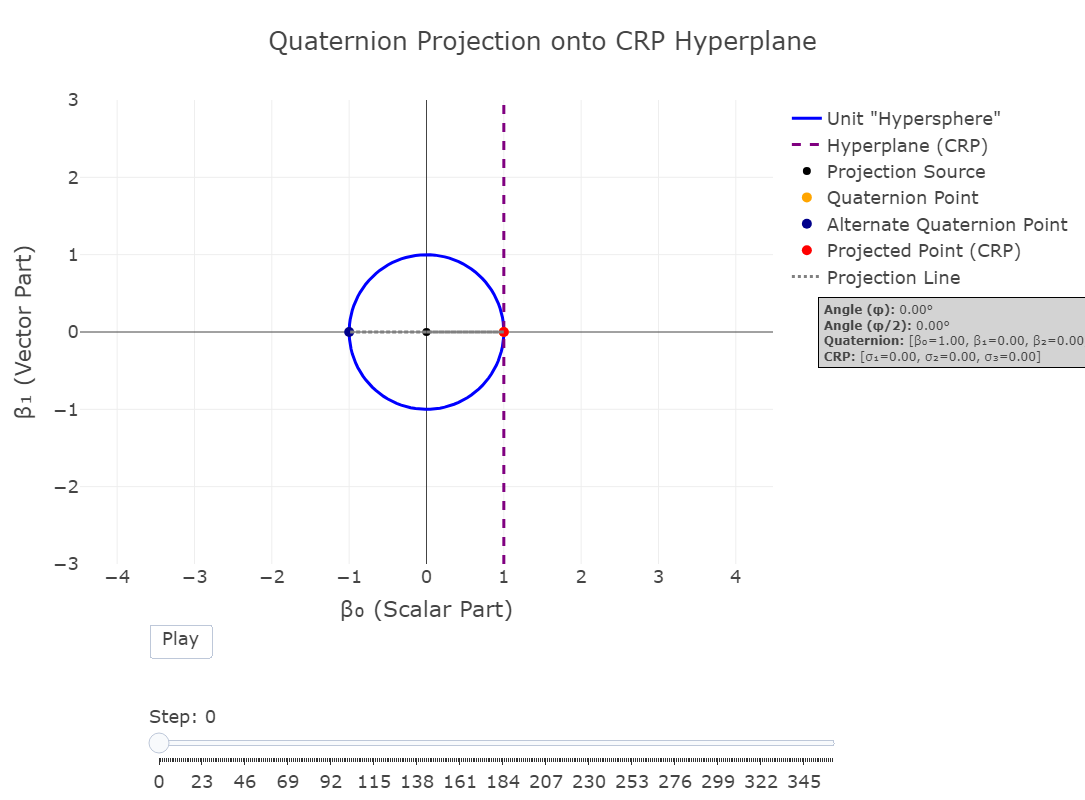

In [31]:
def setup_animation_scene_1(fig, frames, title):
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 50, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.2,
                                    "x": 0.1,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": -0.25,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=800,
                      height=800,
                      template='presentation',
                      xaxis=dict(range=[-1.5, 1.5], scaleanchor="y", scaleratio=1, title='β₀ (Scalar Part)'),
                      yaxis=dict(range=[-3, 3], scaleanchor="x", scaleratio=1, title='β₁ (Vector Part)'),
                      title=title)

def CRP_visualization(steps=360):
    angles_deg = np.arange(0, (steps+1), 1)
    angles_rad = np.deg2rad(angles_deg)
    quaternions, crps, projected_points = [], [], []

    for angle in angles_rad:
        # Correct the quaternion calculation
        q0, q1 = np.cos(angle / 2), np.sin(angle / 2)
        quaternion = np.array([q0, q1, 0, 0])
    
        # Compute the DCM from the quaternion
        dcm = quaternion_to_DCM(quaternion)
    
        # Compute CRP from DCM
        try:
            crp = DCM_to_CRP(dcm)
            crp_value = crp[0]  # Extract σ₁
        
        except ZeroDivisionError:
            # Handle singularity when q0 is zero (180 degrees)
            crp_value = np.inf
    
        # Projected point on hyperplane x = 1
        projected_x, projected_y = (1, crp_value)
    
        quaternions.append(quaternion)
        crps.append([crp_value, 0, 0])
        projected_points.append((projected_x, projected_y))

    circle_angles = np.linspace(0, 2 * np.pi, 100)
    circle_x, circle_y = np.cos(circle_angles), np.sin(circle_angles)

    # Create the initial annotation
    q0_init, q1_init, q2_init, q3_init = quaternions[0]
    projected_y_init = projected_points[0][1]
    angle_deg_init = angles_deg[0]
    annotation_text_init = (f"<b>Angle (φ):</b> {angle_deg_init:.2f}°<br>"
                            f"<b>Angle (φ/2):</b> {angle_deg_init/2:.2f}°<br>"
                            f"<b>Quaternion:</b> [β₀={q0_init:.2f}, β₁={q1_init:.2f}, β₂=0.00, β₃=0.00]<br>"
                            f"<b>CRP:</b> [σ₁={projected_y_init:.2f}, σ₂=0.00, σ₃=0.00]")

    # Calculate the initial alternate quaternion point
    q0_alt_init = -q0_init
    q1_alt_init = -q1_init

    # Define initial data traces
    initial_data = [
        # Unit circle
        go.Scatter(x=circle_x, 
                   y=circle_y, 
                   mode='lines', 
                   line=dict(color='blue'),
                   name='Unit "Hypersphere"',
                   showlegend=True),
        
        # Hyperplane x = 1
        go.Scatter(x=[1, 1], 
                   y=[-3, 3], 
                   mode='lines', 
                   line=dict(color='purple', dash='dash'), 
                   name="Hyperplane (CRP)", 
                   showlegend=True),
        
        # Projection source (origin)
        go.Scatter(x=[0], 
                   y=[0], 
                   mode='markers', 
                   marker=dict(color='black', size=8), 
                   name='Projection Source', 
                   showlegend=True),
        
        # Quaternion point on the unit circle
        go.Scatter(x=[q0_init], 
                   y=[q1_init], 
                   mode='markers', 
                   marker=dict(color='orange', size=10), 
                   name='Quaternion Point', 
                   showlegend=True),
        
        # Alternate quaternion point on the unit circle
        go.Scatter(x=[q0_alt_init], 
                   y=[q1_alt_init],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Alternate Quaternion Point',
                   showlegend=True),
        
        # Projected point on hyperplane
        go.Scatter(x=[projected_points[0][0]], 
                   y=[projected_points[0][1]], 
                   mode='markers', 
                   marker=dict(color='red', size=10), 
                   name='Projected Point (CRP)', 
                   showlegend=True),
        
        # Projection line
        go.Scatter(x=[0, q0_init, q0_alt_init, projected_points[0][0]], 
                   y=[0, q1_init, q1_alt_init, projected_points[0][1]], 
                   mode='lines', 
                   line=dict(color='gray', dash='dot'),
                   name='Projection Line', 
                   showlegend=True)
    ]

    # Create the figure with the initial data and annotation
    fig = go.Figure(data=initial_data, 
                    layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text_init,
                                                                       xref="paper", yref="paper",
                                                                       x=1.55, y=0.5,
                                                                       showarrow=False,
                                                                       align="left",
                                                                       bordercolor="black",
                                                                       borderwidth=1,
                                                                       borderpad=4,
                                                                       bgcolor="lightgrey",
                                                                       font=dict(size=12))]),
                    frames=[])

    frames = []
    for i, angle_deg in enumerate(angles_deg):
        q0, q1, q2, q3 = quaternions[i]
        projected_x, projected_y = projected_points[i]
    
        # Calculate the alternate quaternion point
        q0_alt = -q0
        q1_alt = -q1

        # Use the precomputed CRP values from the crps list
        crp_value = crps[i][0]
    
        if np.isinf(crp_value):
            # Handle full singularity at 180 degrees
            angle_deg_singularity = 180.0  # Since q0 is effectively zero
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg_singularity:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg_singularity/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2e}, β₁={q1:.2e}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁=inf, σ₂=0.00, σ₃=0.00]<br>"
                               f"<span style='color:red;'><b>Singularity at 180 degrees!</b></span>")
        
            # Extend the projection line beyond the quaternion point
            line_end_x = q0 * 2
            line_end_y = q1 * 2
            x_projection_line = [0, q0, q0_alt, line_end_x]
            y_projection_line = [0, q1, q1_alt, line_end_y]
            x_projected_point = []
            y_projected_point = []
        
        elif abs(crp_value) > 2.5:
            # Near singularity condition
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2f}, β₁={q1:.2f}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁={projected_y:.2f}, σ₂=0.00, σ₃=0.00]<br>"
                               f"<span style='color:orange;'><b>Near Singularity</b></span>")
        
            # Project line up to the projected point
            x_projection_line = [0, q0, q0_alt, projected_x]
            y_projection_line = [0, q1, q1_alt, projected_y]
            x_projected_point = [projected_x]
            y_projected_point = [projected_y]
        
        else:
            # Normal case
            annotation_text = (f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
                               f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
                               f"<b>Quaternion:</b> [β₀={q0:.2f}, β₁={q1:.2f}, β₂=0.00, β₃=0.00]<br>"
                               f"<b>CRP:</b> [σ₁={projected_y:.2f}, σ₂=0.00, σ₃=0.00]")
        
            x_projection_line = [0, q0, q0_alt, projected_x]
            y_projection_line = [0, q1, q1_alt, projected_y]
            x_projected_point = [projected_x]
            y_projected_point = [projected_y]



        # Update the data of existing traces
        frame = go.Frame(
            data=[
                # Unit circle (no change)                   
                go.Scatter(),
            
                # Hyperplane x = 1 (no change)
                go.Scatter(),
            
                # Projection source (origin) (no change)
                go.Scatter(),
                
                # Quaternion point on the unit circle
                go.Scatter(x=[q0], y=[q1]),
                
                # Alternate quaternion point on the unit circle
                go.Scatter(x=[q0_alt], y=[q1_alt]),
                
                # Projected point on hyperplane
                go.Scatter(x=x_projected_point, y=y_projected_point),
                
                # Projection line
                go.Scatter(x=x_projection_line, y=y_projection_line)],
            name=str(i),
            layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text,
                                                               xref="paper", yref="paper",
                                                               x=1.55, y=0.5,  
                                                               showarrow=False,
                                                               align="left",
                                                               bordercolor="black",
                                                               borderwidth=1,
                                                               borderpad=4,
                                                               bgcolor="lightgrey",
                                                               font=dict(size=12))]))
        frames.append(frame)

    fig.frames = frames  # Add frames to the figure

    # Configure the layout using your original setup_animation_scene function
    setup_animation_scene_1(fig, frames, "Quaternion Projection onto CRP Hyperplane")

    return fig

# Run the visualization
fig = CRP_visualization(steps=360)
fig.show()

## 3.3.7 - Summary of CRPs

- CRPs offer a compact three-parameter set for representing rotations, which makes them more efficient for large-angle rotations compared to Euler angles.
- They are particularly useful for control applications where the dynamics of the system avoid the $180^\circ$ singularity. This singularity can sometimes be an asset for controlling aggressive maneuvers, but in most cases, it is a drawback.
- The linearization of CRPs for small angles makes them suitable for use in tracking errors or small attitude adjustments.
- **Stereographic projection** offers a clear geometric interpretation of CRPs, explaining their behavior as they approach singularity.
- While quaternions have two possible sets (shadow and original), CRPs are unique, making them a stable parameterization for most use cases, except at $180^\circ$.

# 3.4) Modified Rodrigues Parameters (MRPs)

## 3.4.1 - Definitions of MRPs

In three-dimensional rotational dynamics, **Modified Rodrigues Parameters (MRPs)** are widely used due to their advantages over Classical Rodrigues Parameters (CRPs). MRPs are especially useful as they avoid singularities up to a complete 360° rotation, rather than the 180° limitation seen in CRPs.

**<ins>Euler Parameter Relationship</ins>**  
MRPs are defined in terms of Euler parameters (quaternions). For MRPs, the relationship is given by:  
$$
\sigma_i = \frac{\beta_i}{1 + \beta_0}, \quad i = 1, 2, 3
$$
where $\beta_i$ represents the quaternion vector components, and $\beta_0$ is the scalar part of the quaternion. This formulation is **singular** when $\beta_0 = -1$, corresponding to a full 360° rotation.

The inverse relation, going from MRPs to Euler parameters, is given by:  
$$
\beta_0 = \frac{1 - \|\sigma\|^2}{1 + \|\sigma\|^2}, \quad \beta_i = \frac{2\sigma_i}{1 + \|\sigma\|^2}, \quad i = 1, 2, 3
$$
This relation will be **singular** if $\sigma$ tends to infinity, which would correspond to a 360° rotation.

**<ins>PRV Relationship</ins>**  
MRPs can also be defined directly in terms of the Principal Rotation Vector (PRV):  
$$
\sigma = \tan\left(\frac{\Phi}{4}\right) \hat{e}
$$
where $\Phi$ is the principal rotation angle and $\hat{e}$ is the unit vector along the rotation axis. 

This **linearizes** to, 
$$
\sigma \approx \left(\frac{\Phi}{4}\right) \hat{e}
$$

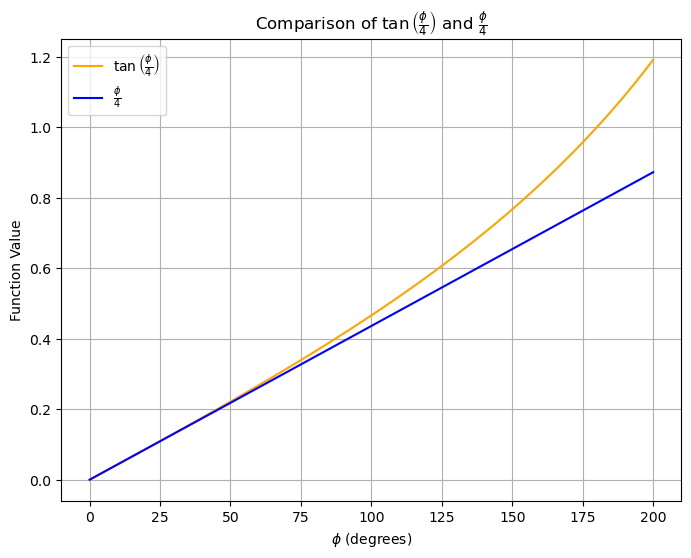

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Use inline plotting to avoid JavaScript dependency
%matplotlib inline

# Define a narrower range of angles to "zoom in" on the difference
phi = np.linspace(0, 200, 500)  # Limiting to 100 degrees for a closer comparison

# Calculate tan(phi/4) and phi/4
tan_phi4 = np.tan(np.radians(phi / 4))
linear_phi4 = np.radians(phi / 4)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(phi, tan_phi4, label=r'$\tan\left(\frac{\phi}{4}\right)$', color='orange')
plt.plot(phi, linear_phi4, label=r'$\frac{\phi}{4}$', color='blue')
plt.xlabel(r'$\phi$ (degrees)')
plt.ylabel('Function Value')
plt.title(r'Comparison of $\tan\left(\frac{\phi}{4}\right)$ and $\frac{\phi}{4}$')
plt.legend()
plt.grid()
plt.show()

**<ins>CRP Relationship</ins>**  
MRPs and CRPs can be interconverted as follows:  
$$
q = \frac{2\sigma}{1 - \|\sigma\|^2}, \quad \sigma = \frac{q}{1 + \sqrt{1 + q^T q}}
$$

**<ins>Relationship to DCM</ins>**  
MRPs are related to the Direction Cosine Matrix (DCM) as follows:  
$$
[\tilde{\sigma}] = \frac{[C]^T - [C]}{\zeta(\zeta + 2)}
$$
where,
$$\zeta = \sqrt{\text{trace}([C]) + 1} = \beta_0 / 2$$ 

The MRP vector $\sigma$ components in terms of DCM elements $C_{ij}$ are:  
$$
\sigma = \begin{pmatrix} \sigma_1 \\ \sigma_2 \\ \sigma_3 \end{pmatrix} = \frac{1}{\zeta(\zeta + 2)} \begin{pmatrix} C_{23} - C_{32} \\ C_{31} - C_{13} \\ C_{12} - C_{21} \end{pmatrix}
$$

**<ins>Advantages of MRPs</ins>**  
The key advantage of MRPs is their ability to shift the singularity from 180° (as in CRPs) to 360°. This means MRPs can handle complete 360° rotations, making them more robust in applications involving large rotations. Additionally, MRPs linearize well, which is beneficial for control and feedback applications where linearized models are preferred. For instance, the MRP relationship to PRV provides a linear approximation to angles, allowing for better performance in large-angle feedback systems.

MRPs are particularly useful in applications that require **non-singular attitude representations** for rotations approaching 360°, which can be challenging to handle with other parametrizations such as quaternions or CRPs.

### 3.4.1.1 - Stereographic Projection of MRP

<div align="center">
  <img src="Images/MRP Stereographic Projection Slide.png" alt="Alt text" width="750"/>
</div>

In three-dimensional rotational dynamics, **stereographic projection** provides a method to map rotation states on a sphere (the set of Euler parameters) onto a plane, thereby facilitating the representation of orientations as Modified Rodrigues Parameters (MRPs). This technique is especially useful in avoiding the 180° singularity observed in Classical Rodrigues Parameters (CRPs) by shifting the singularity to a full 360° rotation.

**<ins>Projection Setup</ins>**  
- **Projection Point**: Located at $(-1, 0, 0, 0)$ along the $\beta_0$ axis.
- **Projection Plane**: Defined by $\beta_0 = 0$, serving as the hyperplane onto which points from the unit sphere (the set of rotation states) are projected.

By using this projection setup, any point on the sphere can be mapped onto the hyperplane to define a unique MRP vector.

**<ins>Projection Process</ins>**  
1. Take any point on thhypere **unit sphere** representing an attitude or rotation.
2. Draw a line from the **projection point** (at $(-1, 0, 0, 0)$) through this poihypernt on the sphere.
3. Locate the **intersection** of this li 3D hyperprojection plane ($\beta_0 = 0$). The coordinates of this intersection give the MRP vector $\sigma$, effectively representing the rotation in a compact and continuous manner.

**<ins>Key Properties</ins>**  
- **Linearization of MRPs**: MRPs provide a nearly linear approximation for rotation angles up to approximately 180°, making them advantageous for control applications where smooth transitions are needed.
- **Singularity Shift to 360°**: Unlike CRPs, which are singular at 180°, MRPs are only singular at 360° rotations, offering a wider range of continuous rotation representation.

**<ins>Practical Implications</ins>**  
This projection method enables efficient and robust attitude representation in control systems, as it allows the **norm of the MRP vector** to indicate rotation size:
  - If $\| \sigma \| < 1$, the rotation is less than 180°.
  - If $\| \sigma \| = 1$, the rotation is exactly 180°.
  - If $\| \sigma \| > 1$, the rotation exceeds 180° (indicating a long rotation).

The **stereographic projection** approach with MRPs thus provides an intuitive and manageable way to represent 3D orientations, minimizing singularities and maintaining continuity across a wide range of rotational states.


### 3.4.1.2 - Shadow MRP Set

In cases where an MRP norm $\|\sigma\|$ exceeds 1 (i.e., describing a "long" rotation over 180°), we switch to the **Shadow MRP Set** to avoid singularities. The shadow MRPs, $\sigma^S$, provide an alternate representation, ensuring stable attitude descriptions.

**Definition of Shadow MRPs**  
Using the alternate set of Euler parameters, the shadow MRPs are defined as:
$$
\sigma_i^S = -\frac{\beta_i}{1 - \beta_0} = -\frac{\sigma_i}{\sigma^2}, \quad i = 1, 2, 3
$$

**Switching Criterion**  
A common surface for switching between the primary and shadow MRP sets is $\sigma \cdot \sigma = 1$, with conditions as follows:
- $\|\sigma\| \leq 1$ for $\Phi \leq 180^\circ$
- $\|\sigma\| \geq 1$ for $\Phi \geq 180^\circ$
- $\|\sigma\| = 1$ for $\Phi = 180^\circ$

**Shadow MRP Calculation**  
When the principal rotation angle $\Phi$ exceeds 180°, the shadow MRP vector $\sigma^S$ is calculated as:
$$
\sigma^S = \tan \left( \frac{\Phi - 2\pi}{4} \right) \hat{e}
$$
where $\hat{e}$ is the unit vector along the rotation axis.

If $\Phi' \leq 180^\circ$, the shadow MRP representation linearizes to:
$$
\sigma^S \approx \left( \frac{\Phi'}{4} \right) \hat{e}
$$
By switching to the shadow set when $\|\sigma\| > 1$, we maintain a bounded and well-behaved MRP description throughout all rotations, avoiding instability at $\Phi = 360^\circ$.


<div align="center">
  <img src="Images/MRP Shadow Set.png" alt="Alt text" width="750"/>
</div>

**<ins>Visualizing the Shadow Set of MRPs</ins>**  

Imagine an MRP unit sphere centered at the origin in three-dimensional space. This sphere represents all possible rotation states that can be described using MRPs, with the surface of the sphere corresponding to rotations of exactly 180 degrees.

**<ins>Primary MRPs Within the Unit Sphere</ins>**  
- **Rotations Less Than 180 Degrees:**  
  - When the rotation angle is less than 180 degrees, the MRPs have a norm (magnitude) less than 1.
  - These MRPs are represented as points inside the MRP unit sphere.
  - As the rotation angle increases from 0 to 180 degrees, the MRP vector moves from the origin toward the surface of the sphere.

**<ins>Rotations Exceeding 180 Degrees</ins>**  
- **Challenge for MRPs Beyond 180 Degrees:**  
  - For rotations greater than 180 degrees, the MRPs would have a norm greater than 1 if we continued using the same parameterization.
  - This would place the MRP vector outside the unit sphere, leading to computational issues and instability.

**<ins>Introducing the Shadow Set</ins>**  
- **Solution to Extend Beyond 180 Degrees:**  
  - Instead of allowing MRPs to exceed a norm of 1, we switch to the **Shadow Set** when the norm reaches 1.
  - The Shadow Set maps the MRPs back inside the unit sphere, ensuring the norm remains less than 1.
  - This allows for a continuous and smooth representation of rotations beyond 180 degrees.

**<ins>How the Shadow Set Works</ins>**  
- **Transition Between Primary and Shadow Sets:**  
  - As the MRP norm reaches 1 at a 180-degree rotation, the Shadow Set takes over to represent rotations beyond this angle.
  - The Shadow Set essentially “reflects” the MRP vector back inside the unit sphere, keeping the representation within the boundary.

**<ins>Visualization of Shadow Set Transition</ins>**  
- **Grey Line and Black Line:**  
  - The **grey line** represents the primary MRP set, which describes the rotation until it approaches 180 degrees (norm = 1).
  - At 180 degrees, the MRP vector moves to the **black line**, representing the Shadow Set, which smoothly continues the rotation description.
  - This transition avoids the singularity at 360 degrees, allowing MRPs to represent any rotation without instability.

**<ins>Key Points</ins>**  
- **Rotation Representation Remains Within the Sphere:**  
  - The Shadow Set ensures that the MRP vector stays within the unit sphere regardless of the rotation angle.
- **Continuous Representation:**  
  - By switching to the Shadow Set at 180 degrees, we avoid any jumps or discontinuities in the representation.

**<ins>Why Use the Shadow Set?</ins>**  
- **Avoiding Singularities**  
  - **Singularity at 360 Degrees:** MRPs have a singularity at a rotation of exactly 360 degrees, which is avoided by using the Shadow Set to switch smoothly at 180 degrees.
  - **Maintaining Stability:** Keeping the MRPs within the unit sphere (norm less than 1) ensures numerical stability and avoids computational issues.
- **Consistent Parameter Range**  
  - **Bounded Parameters:** The parameters remain bounded between -1 and 1, simplifying algorithms that use MRPs.
  - **Ease of Implementation:** Control systems and simulations can handle MRPs more efficiently when their magnitude is limited.
iciently when their magnitude is limited.


## 3.4.2 - Relationship to DCMs

**<ins>Matrix Components</ins>**  
The Direction Cosine Matrix (DCM), denoted as $[C]$, is defined as:
$$
[C] = \frac{1}{(1 + \sigma^2)^2} \begin{bmatrix} 
4 (\sigma_1^2 - \sigma_2^2 - \sigma_3^2) + (1 - \sigma^2)^2 & 8 \sigma_1 \sigma_2 + 4 \sigma_3 (1 - \sigma^2) & 8 \sigma_1 \sigma_3 - 4 \sigma_2 (1 - \sigma^2) \\ 
8 \sigma_1 \sigma_2 - 4 \sigma_3 (1 - \sigma^2) & 4 (- \sigma_1^2 + \sigma_2^2 - \sigma_3^2) + (1 - \sigma^2)^2 & 8 \sigma_2 \sigma_3 + 4 \sigma_1 (1 - \sigma^2) \\ 
8 \sigma_3 \sigma_1 + 4 \sigma_2 (1 - \sigma^2) & 8 \sigma_3 \sigma_2 - 4 \sigma_1 (1 - \sigma^2) & 4 (- \sigma_1^2 - \sigma_2^2 + \sigma_3^2) + (1 - \sigma^2)^2 
\end{bmatrix}
$$
This matrix provides a mapping from Modified Rodrigues Parameters (MRPs) to the DCM, allowing for a direct transformation between MRP space and rotational matrices.

**<ins>Vector Computation</ins>**  
An alternative vector-based formulation is:
$$
[C] = [I_{3 \times 3}] + \frac{8 \left[\tilde{\sigma}\right]^2 - 4 (1 - \sigma^2) \left[\tilde{\sigma}\right]}{(1 + \sigma^2)^2}
$$

where $\tilde{\sigma}$ represents the skew-symmetric matrix form of the MRP vector $\sigma$, providing an efficient way to compute $[C]$ from MRPs.

**<ins>Properties</ins>**  
1. **Transpose and Inverse Relation**: The inverse of the DCM is identical to its transpose and can be expressed as:
   $$
   [C(\sigma)]^{-1} = [C(\sigma)]^T = [C(-\sigma)]
   $$
   This property simplifies transformations between frames. For example, if $[C(\sigma)]$ represents a rotation from frame $N$ to frame $B$, then $[C(-\sigma)]$ represents the inverse rotation, from $B$ back to $N$, achieved by flipping the sign of the MRP vector.

2. **Ease of Inversion**: This relation enables straightforward computation of inverse transformations without recalculating complex angles. Unlike with Euler angles, where reversal requires recomputation, MRPs allow frame transformations by simply flipping the sign, maintaining computational simplicity.

3. **Pseudo-Vector Behavior**: Although MRPs are not true vectors, they exhibit pseudo-vector-like properties under specific transformations, which adds to their utility in representing rotations and simplifies certain attitude computations.

This DCM formulation offers a compact, computationally efficient representation for rotational dynamics, making it especially valuable in applications requiring frequent transformations between reference frames.

In [33]:
def MRP_to_DCM(sigma):
    """
    Converts a Modified Rodrigues Parameter (MRP) vector to a Direction Cosine Matrix (DCM).

    Args:
        sigma (numpy.ndarray): A 3-element array representing the MRP vector.

    Returns:
        numpy.ndarray: A 3x3 DCM matrix.
    """
    # Ensure sigma is a numpy array
    sigma = np.asarray(sigma).flatten()

    if sigma.shape[0] != 3:
        raise ValueError("Input sigma vector must be of length 3.")

    # Compute the Skew-Symmetric matrix of Sigma
    sigma_tilde = skew_symmetric(sigma)

    # 3x3 Identity Matrix
    I_3x3 = np.eye(3)

    # Comput the norm of MRP vector, sigma_squared
    sigma_squared = np.dot(sigma, sigma)

    # Vector Based Computation
    C = I_3x3 + ((8 * np.dot(sigma_tilde, sigma_tilde)) - (4 * (1 - sigma_squared) * sigma_tilde)) / ((1 + sigma_squared)**2)

    return C

# Example Usage:
phi = np.deg2rad(90)  # Convert 90 degrees to radians
e = np.array([0, 0, 1])  # Rotation axis (z-axis)
sigma = e * np.tan(phi / 4)
MRP_to_DCM(sigma)

array([[ 0.,  1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [34]:
def DCM_to_MRP(C):
    """
    Converts a Direction Cosine Matrix (DCM) to a Modified Rodrigues Parameter (MRP) vector.

    Args:
        C (numpy.ndarray): A 3x3 DCM matrix.

    Returns:
        numpy.ndarray: A 3-element array representing the MRP vector (sigma).
    """
    # Ensure C is a numpy array
    C = np.asarray(C)
    if C.shape != (3, 3):
        raise ValueError("Input DCM must be a 3x3 matrix.")

    # Convert DCM to quaternion, [q0, q1, q2, q3]
    q = DCM_to_quaternion(C)  

    # Ensure quaternion is normalized
    #q = q / np.linalg.norm(q)

    # Extract scalar and vector parts
    q0 = q[0]  # Scalar part
    qv = q[1:]  # Vector part (3-element array)

    # Handle the case when q0 is negative to ensure |sigma| <= 1
    if q0 < 0:
        q0 = -q0
        qv = -qv

    # Compute MRP vector
    sigma = qv / (1 + q0)

    return sigma

# Define the DCM
C = np.array([[0, 1, 0],
              [-1,  0, 0],
              [0,  0, 1]])

# Compute the MRP vector
sigma = DCM_to_MRP(C)

print("MRP vector sigma:", sigma)

MRP vector sigma: [0.         0.         0.41421356]


In [35]:
MRP_to_DCM(np.array([0.1, 0.2, 0.3]))

array([[ 0.19975377,  0.91720529, -0.34472145],
       [-0.67097568,  0.38442598,  0.63404124],
       [ 0.71406587,  0.10464758,  0.69221299]])

In [36]:
C = np.array([[0.763314, 0.0946746, -0.639053],
              [-0.568047, -0.372781, -0.733728],
              [-0.307692, 0.923077, -0.230769]])

# Compute the MRP vector
sigma = DCM_to_MRP(C)

print("MRP vector sigma:", sigma)

MRP vector sigma: [-0.49999999  0.09999991  0.19999987]


## 3.4.3 - MRPs Addition/Subtraction

The Modified Rodrigues Parameters (MRPs) allow for computationally efficient attitude addition and subtraction without the need to map into and out of Direction Cosine Matrices (DCMs). This direct approach is particularly valuable in scenarios where the computational overhead of 3x3 matrix operations is a constraint.

**<ins>DCM Method</ins>**  
For addition and subtraction of attitudes, one method involves mapping the MRPs into DCMs, performing the matrix multiplication of the DCMs, and then converting the result back to the desired coordinate set. This method is computationally reliable but less efficient due to the matrix operations involved. The DCM method can be expressed as:
$$
[FN(\sigma)] = [FB(\sigma'')][BN(\sigma')]
$$
where:
- **σ′** represents the initial MRP rotation.
- **σ″** represents the additional MRP rotation applied to the initial rotation.

**<ins>Direct MRP Addition Property</ins>**  
A direct addition property exists for MRPs, bypassing the need for DCMs. The addition of two MRP rotations, **σ′** and **σ″**, can be represented as:
$$
\sigma = \frac{(1 - |\sigma'|^2)\sigma'' + (1 - |\sigma''|^2)\sigma' - 2\sigma'' \times \sigma'}{1 + |\sigma'|^2|\sigma''|^2 - 2\sigma' \cdot \sigma''}
$$
This formula provides a direct calculation of the combined attitude, avoiding the blow-up that occurs with CRPs when rotations sum to 180 degrees.

**<ins>Singularity Handling in MRP Addition</ins>**  
If two 180-degree rotations are added, resulting in a 360-degree rotation about the same axis, the denominator in the addition formula approaches zero, indicating a singularity. Since MRPs have a non-unique representation, this singularity can be handled by switching to the "shadow set." For example, adding a 180-degree rotation to another 180-degree rotation can be achieved by using a negative 180-degree rotation instead. This technique ensures a non-singular result, leveraging the flexibility of MRPs.

**<ins>Practical Implementation for Singularity Check</ins>**  
To avoid singularity, an `if` statement can be added to detect when the denominator is near zero. When this condition is met, the MRPs can be switched to their alternate set, thus preventing computational issues. This check does not need extreme precision; a tolerance near zero is sufficient to handle most cases.

**<ins>Subtraction of Attitude using MRPs</ins>**  
The subtraction of two attitudes can also be achieved directly in MRP space by using a negative MRP vector:
$$
\sigma'' = \frac{(1 - |\sigma'|^2)\sigma - (1 - |\sigma|^2)\sigma' + 2\sigma \times \sigma'}{1 + |\sigma'|^2|\sigma|^2 + 2\sigma \cdot \sigma'}
$$
Alternatively, subtracting **σ′** from **σ** is equivalent to adding **-σ′**. This symmetry allows for efficient computation of relative attitudes using the same addition formula by simply negating one of the MRPs.

**<ins>Advantages of Direct MRP Operations</ins>**  
The direct addition and subtraction formulas for MRPs offer significant computational advantages:
1. **Non-Singular Transformations**: The flexibility of switching to the shadow set eliminates singularities at 360 degrees, unlike CRPs.
2. **Computational Efficiency**: The direct approach avoids the overhead of DCM matrix operations, making it suitable for onboard computing with limited resources.
3. **Reliability**: For cases where precise numerical stability is critical, DCMs remain an option, though MRPs provide a faster and simpler alternative for most practical applications.

## 3.4.4 - MRPs Kinematic Differential Equation

**Differential Kinematic Equations for MRPs**  

The differential kinematic equation relates the attitude coordinate rates to angular velocity $\boldsymbol{\omega}$. The matrix component form of this equation is:

$$
\dot{\boldsymbol{\sigma}} = \frac{1}{4} \begin{bmatrix} 
1 - \sigma^2 + 2 \sigma_1^2 & 2 (\sigma_1 \sigma_2 - \sigma_3) & 2 (\sigma_1 \sigma_3 + \sigma_2) \\ 
2 (\sigma_2 \sigma_1 + \sigma_3) & 1 - \sigma^2 + 2 \sigma_2^2 & 2 (\sigma_2 \sigma_3 - \sigma_1) \\ 
2 (\sigma_3 \sigma_1 - \sigma_2) & 2 (\sigma_3 \sigma_2 + \sigma_1) & 1 - \sigma^2 + 2 \sigma_3^2 
\end{bmatrix} \boldsymbol{\omega^B}
$$

This form is computationally convenient, with a factor of $\frac{1}{4}$, allowing for efficient implementation in control systems.

**Vector Computation**  

Alternatively, the vector form of the equation is given by:
$$
\dot{\boldsymbol{\sigma}} = \frac{1}{4} \left[ (1 - \sigma^2) \boldsymbol{I}_{3 \times 3} + 2 \left[ \tilde{\sigma} \right] + 2 \boldsymbol{\sigma} \boldsymbol{\sigma}^T \right] \boldsymbol{\omega} = \frac{1}{4} [B(\sigma)] \boldsymbol{\omega}
$$
This form also contains only quadratic terms, with no division by zero issues, making it singular at $\Phi = \pm 360^\circ$.

**Inverting the Differential Kinematic Equation**  

To find $\boldsymbol{\omega}$ from $\dot{\boldsymbol{\sigma}}$, we invert the differential kinematic equation:
$$
\boldsymbol{\omega} = 4 [B]^{-1} \dot{\boldsymbol{\sigma}}
$$

The **near-orthogonality** of the $B$ matrix implies:
$$
[B]^{-1} = \frac{1}{(1 + \sigma^2)^2} [B]^T
$$
which simplifies inversion and provides the transformation:
$$
\boldsymbol{\omega} = \frac{4}{(1 + \sigma^2)^2} [B]^T \dot{\boldsymbol{\sigma}}
$$

**Efficient Integration Using Shadow Set Switching**  

For stable integration, switch to the **shadow set** when $\|\boldsymbol{\sigma}\| > 1$, representing rotations exceeding $180^\circ$. Implement this switch by setting:
$$
\boldsymbol{\sigma} = -\frac{\boldsymbol{\sigma}}{\sigma^2}
$$

This maintains the non-singular nature of MRPs during integration without requiring renormalization as in quaternions, thus simplifying the integration and maintaining computational efficiency.

## 3.4.5 - Cayley Transform 

## 3.4.6 - Visualizing MRPs 

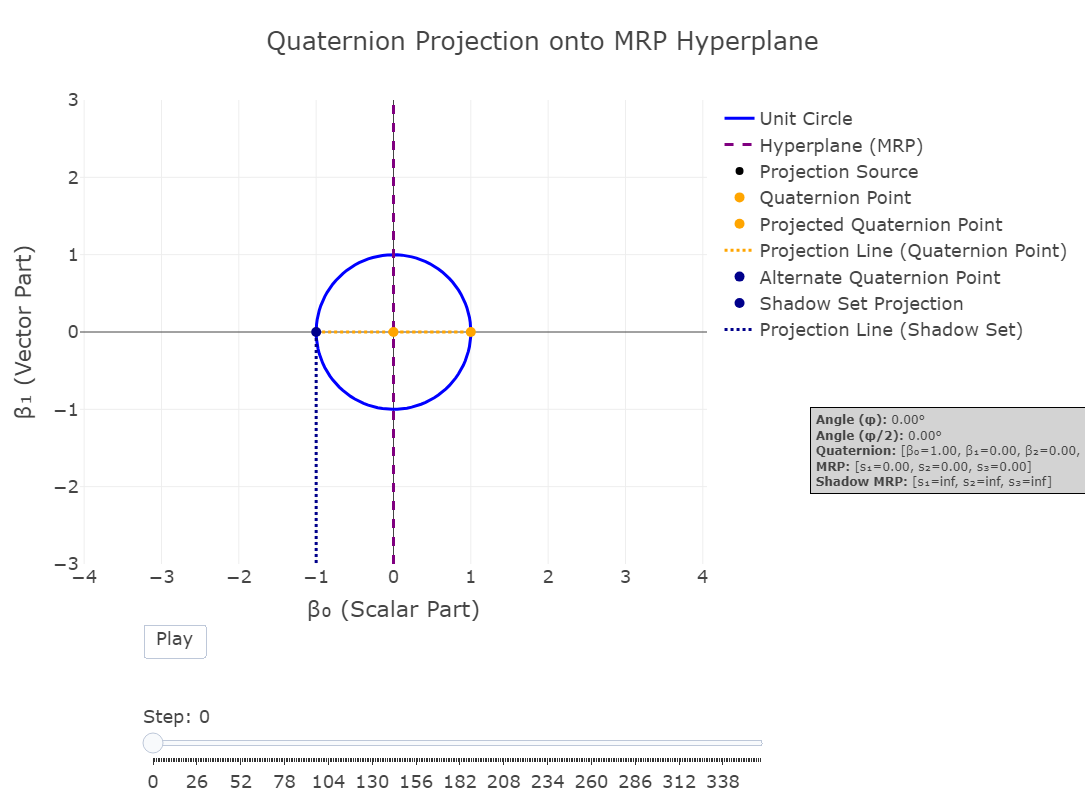

In [37]:
def setup_animation_scene_2(fig, frames, title):
    play_button = {"label": 'Play',
                   "method": 'animate',
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                   "fromcurrent": True,
                                   "mode": 'immediate'}]}

    slider_steps = [{"method": 'animate',
                     "args": [[f.name], {"mode": 'immediate',
                                         "frame": {"duration": 50, "redraw": True},
                                         "fromcurrent": True}],
                     "label": str(k)} for k, f in enumerate(frames)]

    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.2,
                                    "x": 0.1,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [play_button]}],
                      sliders=[{"steps": slider_steps,
                                "x": 0.1,
                                "y": -0.25,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}],
                      width=800,
                      height=800,
                      template='presentation',
                      xaxis=dict(range=[-1.5, 1.5], scaleanchor="y", scaleratio=1, title='β₀ (Scalar Part)'),
                      yaxis=dict(range=[-3, 3], scaleanchor="x", scaleratio=1, title='β₁ (Vector Part)'),
                      title=title)

def MRP_visualization(steps=360):
    angles_deg = np.linspace(0, 360, steps + 1)
    angles_rad = np.deg2rad(angles_deg)
    
    quaternions = []
    mrps = []
    shadow_mrps = []

    for angle_rad in angles_rad:
        # Compute quaternion components
        beta_0 = np.cos(angle_rad / 2)
        beta_1 = np.sin(angle_rad / 2)
        beta_2 = 0.0
        beta_3 = 0.0
        quaternion = np.array([beta_0, beta_1, beta_2, beta_3])

        # Compute beta_i vector (vector part of quaternion)
        beta_i = np.array([beta_1, beta_2, beta_3])

        # Compute principal MRP
        if np.isclose(1 + beta_0, 0, atol=1e-6):
            mrp = np.array([np.inf, np.inf, np.inf])
        else:
            mrp = beta_i / (1 + beta_0)

        # Compute shadow MRP with negative sign
        if np.isclose(1 - beta_0, 0, atol=1e-6):
            shadow_mrp = np.array([np.inf, np.inf, np.inf])
        else:
            shadow_mrp = -beta_i / (1 - beta_0)

        quaternions.append(quaternion)
        mrps.append(mrp)
        shadow_mrps.append(shadow_mrp)

    # Generate unit circle
    circle_angles = np.linspace(0, 2 * np.pi, 100)
    circle_x, circle_y = np.cos(circle_angles), np.sin(circle_angles)

    # Initial values
    beta_0_init, beta_1_init, beta_2_init, beta_3_init = quaternions[0]
    mrp_init = mrps[0]
    shadow_mrp_init = shadow_mrps[0]
    angle_deg_init = angles_deg[0]

    # Prepare initial annotation
    annotation_text_init = (
        f"<b>Angle (φ):</b> {angle_deg_init:.2f}°<br>"
        f"<b>Angle (φ/2):</b> {angle_deg_init/2:.2f}°<br>"
        f"<b>Quaternion:</b> [β₀={beta_0_init:.2f}, β₁={beta_1_init:.2f}, β₂={beta_2_init:.2f}, β₃={beta_3_init:.2f}]<br>"
        f"<b>MRP:</b> [s₁={mrp_init[0]:.2f}, s₂={mrp_init[1]:.2f}, s₃={mrp_init[2]:.2f}]<br>"
        f"<b>Shadow MRP:</b> [s₁={shadow_mrp_init[0]:.2f}, s₂={shadow_mrp_init[1]:.2f}, s₃={shadow_mrp_init[2]:.2f}]"
    )

    # Initial data traces
    initial_data = [
        # Unit circle
        go.Scatter(x=circle_x,
                   y=circle_y,
                   mode='lines',
                   line=dict(color='blue'),
                   name='Unit Circle',
                   showlegend=True),
        
        # MRP Hyperplane at x = 0
        go.Scatter(x=[0, 0],
                   y=[-3, 3],
                   mode='lines',
                   line=dict(color='purple', dash='dash'),
                   name="Hyperplane (MRP)",
                   showlegend=True),
        
        # Projection source at (-1, 0)
        go.Scatter(x=[-1],
                   y=[0],
                   mode='markers',
                   marker=dict(color='black', size=8),
                   name='Projection Source',
                   showlegend=True),
        
        # Quaternion point
        go.Scatter(x=[beta_0_init],
                   y=[beta_1_init],
                   mode='markers',
                   marker=dict(color='orange', size=10),
                   name='Quaternion Point',
                   showlegend=True),

        # Projected point (principal MRP)
        go.Scatter(x=[0],
                   y=[mrp_init[0]],
                   mode='markers',
                   marker=dict(color='orange', size=10),
                   name='Projected Quaternion Point',
                   showlegend=True),

        # Projection line (principal MRP)
        go.Scatter(x=[-1, beta_0_init, 0],
                   y=[0, beta_1_init, mrp_init[0]],
                   mode='lines',
                   line=dict(color='orange', dash='dot'),
                   name='Projection Line (Quaternion Point)',
                   showlegend=True),
        
        # Alternate quaternion point
        go.Scatter(x=[-beta_0_init],
                   y=[-beta_1_init],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Alternate Quaternion Point',
                   showlegend=True),
        
        # Shadow projected point
        go.Scatter(x=[0],
                   y=[shadow_mrp_init[0]],
                   mode='markers',
                   marker=dict(color='darkblue', size=10),
                   name='Shadow Set Projection',
                   showlegend=True),
        
        # Projection line (shadow MRP)
        go.Scatter(x=[-1, -beta_0_init, 0],
                   y=[0, -beta_1_init, -1e6],#shadow_mrp_init[0]],
                   mode='lines',
                   line=dict(color='darkblue', dash='dot'),
                   name='Projection Line (Shadow Set)',
                   showlegend=True),
    ]

    # Create the figure with the initial data and annotation
    fig = go.Figure(data=initial_data,
                    layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text_init,
                                                                       xref="paper", yref="paper",
                                                                       x=1.7, y=0.15,
                                                                       showarrow=False,
                                                                       align="left",
                                                                       bordercolor="black",
                                                                       borderwidth=1,
                                                                       borderpad=4,
                                                                       bgcolor="lightgrey",
                                                                       font=dict(size=12))]),
                    frames=[])

    frames = []
    for i, angle_deg in enumerate(angles_deg):
        beta_0, beta_1, beta_2, beta_3 = quaternions[i]
        beta_i = np.array([beta_1, beta_2, beta_3])
        mrp = mrps[i]
        shadow_mrp = shadow_mrps[i]

        # Determine singularities
        singularity_principal = np.isinf(mrp).any()
        singularity_shadow = np.isinf(shadow_mrp).any()

        # Principal MRP data
        if singularity_principal:
            x_projected_point = []
            y_projected_point = []
            x_projection_line = [-1, beta_0, beta_0]
            y_projection_line = [0, beta_1, 1e6]
        else:
            x_projected_point = [0]
            y_projected_point = [mrp[0]]
            x_projection_line = [-1, beta_0, 0]
            y_projection_line = [0, beta_1, mrp[0]]


        # Shadow MRP data
        if singularity_shadow:
            x_shadow_projected_point = []
            y_shadow_projected_point = []
            x_shadow_projection_line = [-1, -beta_0, -beta_0]
            y_shadow_projection_line = [0, -beta_1, -1e6]
        else:
            x_shadow_projected_point = [0]
            y_shadow_projected_point = [shadow_mrp[0]]
            x_shadow_projection_line = [-1, -beta_0, 0]
            y_shadow_projection_line = [0, -beta_1, shadow_mrp[0]]

        # Annotation Text
        annotation_text = (
            f"<b>Angle (φ):</b> {angle_deg:.2f}°<br>"
            f"<b>Angle (φ/2):</b> {angle_deg/2:.2f}°<br>"
            f"<b>Quaternion:</b> [β₀={beta_0:.2f}, β₁={beta_1:.2f}, β₂={beta_2:.2f}, β₃={beta_3:.2f}]<br>"
            f"<b>MRP:</b> [s₁={mrp[0]:.2f}, s₂={mrp[1]:.2f}, s₃={mrp[2]:.2f}]<br>"
            f"<b>Shadow MRP:</b> [s₁={shadow_mrp[0]:.2f}, s₂={shadow_mrp[1]:.2f}, s₃={shadow_mrp[2]:.2f}]"
            )

        if angle_deg < 150:
            annotation_text += "<br><span style='color:yellow;'><b>Using Principal MRP set</b></span>"
        elif 150 <= angle_deg < 180:
            annotation_text += "<br><span style='color:orange;'><b>Preparing to switch to shadow set</b></span>"
        elif angle_deg >= 180:
            annotation_text += "<br><span style='color:darkblue;'><b>Switched to shadow set!</b></span>"

        # Update the data of existing traces
        frame = go.Frame(
            data=[
                # Unit circle (no change)
                go.Scatter(),
                
                # MRP hyperplane (no change)
                go.Scatter(),
                
                # Projection source (no change)
                go.Scatter(),
                
                # Quaternion point
                go.Scatter(x=[beta_0], y=[beta_1]),

                # Projected point (principal MRP)
                go.Scatter(x=x_projected_point, y=y_projected_point),

                # Projection line (principal MRP)
                go.Scatter(x=x_projection_line, y=y_projection_line),
                
                # Alternate quaternion point
                go.Scatter(x=[-beta_0], y=[-beta_1]),
                
                # Shadow projected point
                go.Scatter(x=x_shadow_projected_point, y=y_shadow_projected_point),
                
                # Projection line (shadow MRP)
                go.Scatter(x=x_shadow_projection_line, y=y_shadow_projection_line),
            ],
            name=str(i),
            layout=go.Layout(annotations=[go.layout.Annotation(text=annotation_text,
                                                               xref="paper", yref="paper",
                                                               x=1.7, y=0.15,
                                                               showarrow=False,
                                                               align="left",
                                                               bordercolor="black",
                                                               borderwidth=1,
                                                               borderpad=4,
                                                               bgcolor="lightgrey",
                                                               font=dict(size=12))]))
        frames.append(frame)

    fig.frames = frames  # Add frames to the figure

    # Configure the layout using your existing setup_animation_scene function
    setup_animation_scene_2(fig, frames, "Quaternion Projection onto MRP Hyperplane")

    return fig

# Note: The setup_animation_scene function should be defined as in your existing code.

# Run the visualization
fig = MRP_visualization(steps=360)
fig.show()

# 3.5) Stereographic Orientation Parameters (SOPs)